<a href="https://colab.research.google.com/github/jokerlj92/220320_ML/blob/main/CS224S_HW3_2022_E2E%EF%BC%88%E5%89%AF%E6%9C%AC%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS224S Assignment 3: Deep Learning for End-to-End Speech Recognition

---


This notebook is worth 70 / 100 possible points for homework 3. You should be able to train all models in Colab. We encourage you to read general PyTorch / Lightning tutorials as necessary as you work.

**Note:** You will need to make a copy of this Colab notebook in your Google Drive before you can edit it.




In [ ]:
#@title Setup Cell

#@markdown **Mount Google Drive.** We will use your `cs224s_spring2022`
#@markdown directory in your Google Drive to store all relevant files,
#@markdown including `utils.py`.

# Do not modify.

import os
from google.colab import drive
drive.mount('/content/gdrive')

DRIVE_PATH = '/content/gdrive/My\ Drive/cs224s_spring2022'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

SYM_PATH = '/content/cs224s_spring2022'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

#@markdown **Data.** It takes ~5-10 minutes to download the dataset the first
#@markdown time you run this cell. Afterwards it will stay saved in
#@markdown `cs224s_spring2022/data/harper_valley_bank_minified`.


DATA_PATH = '{}/data'.format(SYM_PATH)
if not os.path.exists(DATA_PATH):
  %mkdir $DATA_PATH
%cd $DATA_PATH
if not os.path.exists(os.path.join(DATA_PATH, 'harper_valley_bank_minified')):
  !wget -q http://web.stanford.edu/class/cs224s/download/harper_valley_bank_minified.zip
  !unzip -q harper_valley_bank_minified.zip
  %rm harper_valley_bank_minified.zip

#@markdown **Experiments.** Model checkpoints will be saved in your
#@markdown `cs224s_spring2022/trained_models` directory.
MODEL_PATH = '{}/trained_models'.format(SYM_PATH)
if not os.path.exists(MODEL_PATH):
  %mkdir $MODEL_PATH

%cd $SYM_PATH
if not os.path.exists(os.path.join(SYM_PATH, 'utils.py')):
  !wget -q http://web.stanford.edu/class/cs224s/download/utils.py

#@markdown **Note on Sessions.** You have to run this cell each new session
#@markdown (sessions either expire after some time or after you close the notebook).
#@markdown You may have to periodically go to **Runtime** > **Factory reset runtime**
#@markdown if you are experiencing Colab environment issues. Requirements must be installed each new session.

!pip -q install pytorch-lightning==1.9.3
!pip install wandb -qqq

from collections import OrderedDict
from itertools import chain

import h5py
import math
import json
import torch
import wandb
import numpy as np
import pytorch_lightning as pl
from glob import glob
import librosa
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
from sklearn.metrics import f1_score
from typing import *
from IPython.display import Audio
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/cs224s_spring2022/data
/content/gdrive/My Drive/cs224s_spring2022


# Part 1: ML Speech Data Pipeline

HarperValleyBank consists of 23 hours of audio from 1,446 human-human conversations between 59 unique speakers. For your convenience, we store in `harper_valley_bank_minified` all utterance audio waveforms as `numpy` arrays in `data.h5` and all transcripts and labels as `numpy` arrays in `labels.npz`.

Our custom dataset class `HarperValleyBank` should inherit `torch.utils.data.Dataset` and overwrite the following methods:
- `__len__` so that `len(dataset)` returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get the `i`th dataset sample.

There are a few special features that the `HarperValleyBank` class should exhibit.
- **Fixed-length data.** Both the extracted audio features and the character labels will inherently be sequences of different lengths. However, in order to store data in a minibatch during training, we need to make the lengths uniform. To do so, we can first enforce a maximum length for audio waves and a maximum length for labels (note that these two maximum lengths are not necessarily the same). We have preprocessed all sequences to be cropped by single utterances as opposed to conversations. Next, we can crop and pad each sequence with a pad token (e.g. `3`) such that all audio sequences and all label sequences are their respective maximum lengths. We will also store the actual lengths of each sequence so that the model does not learn from the padded indices.
- **Sequence representation.** We are training a character-level model, so the ASR model is responsible for predicting each spoken character. Therefore, we must convert our transcript text to a list of indices representing 34 possible characters (see the global variable `VOCAB`) and a few domain-specific tokens (see the global variable `SILENT_VOCAB` e.g. `[laughter]`). Think of each character as its own class.
```
Raw utterance:  hi this is an example .
List of characters: ['h', 'i', ' ', 't', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', 'n', ' ', 'e', 'x', 'a', 'm', 'p', 'l', 'e', ' ', '.']
List of indices: [18, 19, 3, 30, 18, 19, 29, 3, 19, 29, 3, 11, 24, 3, 15, 34, 11, 23, 26, 22, 15, 3, 6]
```
- **Special tokens.** Although this next part is provided, it is worth pointing out. Aside from the padding index, there are three special tokens in our vocabulary:
    - A blank token (`epsilon`, represented by index `0`) which designates a padded index and plays a special role in CTC.
    - A start-of-sentence token (`SOS`, represented by index `1`) which designates the start of a sentence.
    - An end-of-sentence token (`EOS`, represented by index `2`) which designates the end of a sentence.
```
Example label sequence: [18, 19, 3, 30, 18]
Add an END token: [18, 19, 3, 30, 18, 2]
```
Suppose the maximum label sequence has length 10.
```
Padded label sequence: [18, 19, 3, 30, 18, 2, 0, 0, 0, 0]
Label sequence length: 6
```

**It may be helpful to first read through the `HarperValleyBank` starter code and `utils.py` to get familiar with the data pipeline.**

Below, we provide a cell for you to index into the raw data and listen to randomly chosen samples.

In [ ]:
root = os.path.join(DATA_PATH, 'harper_valley_bank_minified')

waveform_h5 = h5py.File(os.path.join(root, 'data.h5'), 'r')
waveform_data = waveform_h5.get('waveforms')

label_data = np.load(os.path.join(root, 'labels.npz'))

assert len(waveform_data) == len(label_data['human_transcripts'])
index = random.randint(0, len(waveform_data) - 1)
w = waveform_data[f'{index}'][:]
t = label_data['human_transcripts'][index]

print('index {}: "{}"\n'.format(index, t))
Audio(w, rate=8000)

index 12111: "hi my name is david jones what are the local branch hours"



## **Task 1.1: Set up primary task data (5 Points)**

**Implementation**

Notice that the `__getitem__` returns 4 objects:
- `inputs`: the padded log-Mel spectrogram features.
- `input_lengths`: the true length of the unpadded spectrogram features.
- `labels`: the padded character labels.
- `label_lengths`: the true length of the unpadded character labels.

These objects will be used for what we call our *primary* task: speech recognition. In later parts, we will use *auxiliary* tasks to perform multi-task learning toward boosting speech recognition.

**→ Implement the `get_primary_task_data` method.** This will be used in the `__getitem__` method of `HarperValleyBank` and later its subclass for multi-task learning, and it is responsible for extracting log-Mel spectrogram features from the raw audio clips. Do not modify other methods. You should pass the sanity check at the end.


In [ ]:
from utils import (
  prune_transcripts, pad_wav, pad_transcript_label, get_transcript_labels,
  get_cer_per_sample)


# HarperValleyBank character vocabulary
VOCAB = [' ', "'", '~', '-', '.', '<', '>', '[', ']', 'a', 'b', 'c', 'd', 'e',
         'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
         't', 'u', 'v', 'w', 'x', 'y', 'z']

SILENT_VOCAB = ['[baby]', '[ringing]', '[laughter]', '[kids]', '[music]',
                '[noise]', '[unintelligible]', '[dogs]', '[cough]']


class HarperValleyBank(Dataset):
  """Dataset to be used to train CTC, LAS, and MTL.

  Args:
    root: string
          path to the data files.
    split: string (default: train)
            choices: train | val | test
            which split of data to load
    n_mels: integer (default: 128)
            number of mel frequencies
    n_fft: integer (default: 256)
            number of fourier components
    win_length: integer (default: 256)
                should be <= n_fft
    hop_length: integer (default: 128)
                number of frames to skip in between
    wav_max_length: integer (default: 200)
                    maximum number of timesteps in a waveform
    transcript_max_length: integer (default: 200)
                            maximum number of timesteps in a transcript
    append_eos_token: boolean (default: False)
                      add EOS token to the end of every transcription
                      this is used for LAS (and LAS+CTC models)
  """
  def __init__(
      self, root, split='train', n_mels=128, n_fft=256, win_length=256,
      hop_length=128, wav_max_length=200, transcript_max_length=200,
      append_eos_token=False):
    super().__init__()
    print(f'> Constructing HarperValleyBank {split} dataset...')

    self.label_data = np.load(os.path.join(root, 'labels.npz'))
    self.root = root
    self.wav_max_length = wav_max_length
    self.transcript_max_length = transcript_max_length

    self.input_dim = n_mels
    self.n_mels = n_mels
    self.n_fft = n_fft
    self.win_length = win_length
    self.hop_length = hop_length

    # Prune away very short examples.
    # This returns a list of indices of examples longer than 3 words.
    valid_indices = prune_transcripts(self.label_data['human_transcripts'])

    # Decides which indices belong to which split.
    train_indices, val_indices, test_indices = self.split_data(valid_indices)

    if split == 'train':
      indices = train_indices
    elif split == 'val':
      indices = val_indices
    elif split == 'test':
      indices = test_indices
    else:
      raise Exception(f'Split {split} not supported.')

    raw_human_transcripts = self.label_data['human_transcripts'].tolist()
    human_transcript_labels = get_transcript_labels(
      raw_human_transcripts, VOCAB, SILENT_VOCAB)

    # Increment all indices by 4 to reserve the following special tokens:
    #   0 for epsilon
    #   1 for start-of-sentence (SOS)
    #   2 for end-of-sentence (EOS)
    #   3 for padding
    num_special_tokens = 4
    human_transcript_labels = [list(np.array(lab) + num_special_tokens)
                                for lab in human_transcript_labels]
    # CTC doesn't use SOS nor EOS; LAS doesn't use EPS but add anyway.
    eps_index, sos_index, eos_index, pad_index = 0, 1, 2, 3

    if append_eos_token:
      # Ensert an EOS token to the end of all the labels.
      # This is important for the LAS objective.
      human_transcript_labels_ = []
      for i in range(len(human_transcript_labels)):
        new_label_i = human_transcript_labels[i] + [eos_index]
        human_transcript_labels_.append(new_label_i)
      human_transcript_labels = human_transcript_labels_
    self.human_transcript_labels = human_transcript_labels

    # Include epsilon, SOS, and EOS tokens.
    self.num_class = len(VOCAB) + len(SILENT_VOCAB) + num_special_tokens
    self.num_labels = self.num_class  # These are interchangeable.
    self.eps_index = eps_index
    self.sos_index = sos_index
    self.eos_index = eos_index
    self.pad_index = pad_index # Use this index for padding.

    self.indices = indices

  def indices_to_chars(self, indices):
    # indices: list of integers in vocab
    # add special characters in front (since we did this above)
    full_vocab = ['<eps>', '<sos>', '<eos>', '<pad>'] + VOCAB + SILENT_VOCAB
    chars = [full_vocab[ind] for ind in indices]
    return chars

  def split_data(self, valid_indices, train_ratio = 0.8, val_ratio = 0.1):
    """Splits data into train, val, and test sets based on speaker. When
    evaluating methods on the test split, we measure how well they generalize
    to new (unseen) speakers.

    Concretely, this stores and returns indices belonging to each split.
    """
    # Fix seed so everyone reproduces the same splits.
    rs = np.random.RandomState(42)

    speaker_ids = self.label_data['speaker_ids']
    unique_speaker_ids = sorted(list(set(speaker_ids)))
    unique_speaker_ids = np.array(unique_speaker_ids)

    # Shuffle so the speaker IDs are distributed.
    rs.shuffle(unique_speaker_ids)

    num_speaker = len(unique_speaker_ids)
    num_train = int(train_ratio * num_speaker)
    num_val = int(val_ratio * num_speaker)
    num_test = num_speaker - num_train - num_val

    train_speaker_ids = unique_speaker_ids[:num_train]
    val_speaker_ids = unique_speaker_ids[num_train:num_train+num_val]
    test_speaker_ids = unique_speaker_ids[num_train+num_val:]

    train_speaker_dict = dict(zip(train_speaker_ids, ['train'] * num_train))
    val_speaker_dict = dict(zip(val_speaker_ids, ['val'] * num_val))
    test_speaker_dict = dict(zip(test_speaker_ids, ['test'] * num_test))
    speaker_dict = {**train_speaker_dict, **val_speaker_dict,
                    **test_speaker_dict}

    train_indices, val_indices, test_indices = [], [], []
    for i in range(len(speaker_ids)):
      speaker_id = speaker_ids[i]
      if speaker_dict[speaker_id] == 'train':
          train_indices.append(i)
      elif speaker_dict[speaker_id] == 'val':
          val_indices.append(i)
      elif speaker_dict[speaker_id] == 'test':
          test_indices.append(i)
      else:
          raise Exception('split not recognized.')

    train_indices = np.array(train_indices)
    val_indices = np.array(val_indices)
    test_indices = np.array(test_indices)

    # Make sure to only keep "valid indices" i.e. those with more than 4
    # words in the transcription.
    train_indices = np.intersect1d(train_indices, valid_indices)
    val_indices = np.intersect1d(val_indices, valid_indices)
    test_indices = np.intersect1d(test_indices, valid_indices)

    return train_indices, val_indices, test_indices

  def get_primary_task_data(self, index):
    """Returns audio and transcript information for a single utterance.

    Args:
      index: Index of an utterance.

    Returns:
      log melspectrogram, wav length, transcript label, transcript length
    """
    input_feature = None
    input_length = None
    human_transcript_label = None
    human_transcript_length = None

    wav = self.waveform_data[f'{index}'][:] # An h5py file uses string keys.
    sr = 8000 # We fix the sample rate for you.

    ############################ START OF YOUR CODE ############################
    # TODO(1.1)
    # - Compute the mel spectrogram of the audio crop.
    # - Convert the mel spectrogram to log space and normalize it.
    # - This is your primary task feature. Note that models will expect feature
    #   inputs of shape (T, n_mels).
    # - Pad the feature so that all features are fixed-length and
    #   convert it into a tensor.
    # - Likewise, retrieve and pad the corresponding transcript label sequence.
    #
    # Hint:
    # - Refer to https://librosa.org/doc/latest/index.html.
    # - Use `librosa.feature.melspectrogram` and `librosa.util.normalize`.
    # - Make sure to use our provided sr, n_mels, n_fft, win_length,
    # - and hop_length
    # - utils.py has helpful padding functions.



    melspec = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=self.n_fft, hop_length=self.hop_length, win_length=self.win_length, n_mels=self.n_mels)
    logmelspec = librosa.power_to_db(melspec, ref=np.max)
    feature = librosa.util.normalize(logmelspec)
    input_feature, input_length = pad_wav(feature.T, self.wav_max_length)
    human_transcript_label, human_transcript_length = pad_transcript_label(self.human_transcript_labels[index],self.transcript_max_length)



    ############################# END OF YOUR CODE #############################

    return input_feature, input_length, human_transcript_label, human_transcript_length

  def load_waveforms(self):
    # Make a file pointer to waveforms file.
    waveform_h5 = h5py.File(os.path.join(self.root, 'data.h5'), 'r')
    self.waveform_data = waveform_h5.get('waveforms')

  def __getitem__(self, index):
    """Serves primary task data for a single utterance."""
    if not hasattr(self, 'waveform_data'):
      # Do this in __getitem__ function so we enable multiprocessing.
      self.load_waveforms()
    index = int(self.indices[index])
    return self.get_primary_task_data(index)

  def __len__(self):
    """Returns total number of utterances in the dataset."""
    return len(self.indices)


**Sanity check.** Let's check that your dataset implementation is correct. This will be important to properly run our experiments in later parts. In particular, make sure your `__getitem__` and `__len__` are implemented correctly.

In [ ]:
 # Do not modify.
root = os.path.join(DATA_PATH, 'harper_valley_bank_minified')
train_dataset = HarperValleyBank(root, split='train')
val_dataset = HarperValleyBank(root, split='val')
test_dataset = HarperValleyBank(root, split='test')
assert len(train_dataset) == 10402
assert len(val_dataset) == 679
assert len(test_dataset) == 2854

input, input_length, label, label_length = train_dataset.__getitem__(224)
assert np.shape(input) == torch.Size([train_dataset.wav_max_length, train_dataset.n_mels])
assert input_length == 92
assert label_length == 26
print('\nValidated dataset class implementation!')

> Constructing HarperValleyBank train dataset...
> Constructing HarperValleyBank val dataset...
> Constructing HarperValleyBank test dataset...

Validated dataset class implementation!


# Part 2: Connectionist Temporal Classification (CTC) Neural Network

Our first experiment will be a [Connectionist Temporal Classification](https://www.cs.toronto.edu/~graves/icml_2006.pdf) (Graves et al.) model trained on our primary task of speech recognition.

As an overview, given an input matrix of shape `batch_size x sequence_length x feature_dim`, the network encodes the input speech features with an LSTM, producing a tensor of shape `batch_size x sequence_length x hidden_dim`. Using an additional linear layer, we transform this to `batch_size x sequence_length x vocab_size`, representing the probability of transcribing each character in the vocabulary at each time step. This is directly given to the CTC loss function.

We will use [Weights & Biases](https://wandb.ai) to log loss curves and character error rates (CER) in the cloud. You can create a free account [here](https://wandb.ai/site).

## **CTC Network**

**Implementation**

You will use the CTC objective to train your network. Previously, you implemented the CTC loss function from scratch. For this assignment, you may use PyTorch's implementation. Filling out this section will be necessary to carry out later experiments.

**→ Fill out `get_ctc_loss` using `F.ctc_loss`.**

**→ Read through the starter code and fill out the `forward` pass of `CTCEncoderDecoder`.**

In [ ]:
def get_ctc_loss(
    log_probs, targets, input_lengths, target_lengths, blank=0):
  """Connectionist Temporal Classification objective function."""
  ctc_loss = None
  log_probs = log_probs.contiguous()
  targets = targets.long()
  input_lengths = input_lengths.long()
  target_lengths = target_lengths.long()
  ############################ START OF YOUR CODE ############################
  # TODO(2.1)
  # Hint:
  # - `F.ctc_loss`: https://pytorch.org/docs/stable/nn.functional.html#ctc-loss
  # - log_probs is passed in with shape (batch_size, input_length, num_classes).
  # - Notice that `F.ctc_loss` expects log_probs of shape
  #   (input_length, batch_size, num_classes)
  # - Turn on zero_infinity.
  log_probs = log_probs.transpose(0, 1)

  ctc_loss = F.ctc_loss(
      log_probs, targets, input_lengths, target_lengths, blank=blank, zero_infinity=True)

  ############################# END OF YOUR CODE #############################
  return ctc_loss

In [ ]:
class CTCEncoderDecoder(nn.Module):
  """
  Encoder-Decoder model trained with CTC objective.

  Args:
    input_dim: integer
                number of input features
    num_class: integer
                size of transcription vocabulary
    num_layers: integer (default: 2)
                number of layers in encoder LSTM
    hidden_dim: integer (default: 128)
                number of hidden dimensions for encoder LSTM
    bidirectional: boolean (default: True)
                    is the encoder LSTM bidirectional?
  """
  def __init__(
      self, input_dim, num_class, num_layers=2, hidden_dim=128,
      bidirectional=True):
    super().__init__()
    # Note: `batch_first=True` argument implies the inputs to the LSTM should
    # be of shape (batch_size x T x D) instead of (T x batch_size x D).
    self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True)
    self.decoder = nn.Linear(hidden_dim * 2, num_class)
    self.input_dim = input_dim
    self.num_class = num_class
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    self.embedding_dim = hidden_dim * num_layers * 2 * \
                          (2 if bidirectional else 1)

  def combine_h_and_c(self, h, c):
    """Combine the signals from RNN hidden and cell states."""
    batch_size = h.size(1)
    h = h.permute(1, 0, 2).contiguous()
    c = c.permute(1, 0, 2).contiguous()
    h = h.view(batch_size, -1)
    c = c.view(batch_size, -1)
    return torch.cat([h, c], dim=1)  # just concatenate

  def forward(self, inputs, input_lengths):
    batch_size, max_length, _ = inputs.size()
    # `torch.nn.utils.rnn.pack_padded_sequence` collapses padded sequences
    # to a contiguous chunk
    inputs = torch.nn.utils.rnn.pack_padded_sequence(
        inputs, input_lengths.cpu(), batch_first=True, enforce_sorted=False)
    log_probs = None
    h, c = None, None
    ############################ START OF YOUR CODE ############################
    # TODO(2.1)
    # Hint:
    # - Refer to https://pytorch.org/docs/stable/nn.html
    # - Use `self.encoder` to get the encodings output which is of shape
    #   (batch_size, max_length, num_directions*hidden_dim) and the
    #   hidden states and cell states which are both of shape
    #   (batch_size, num_layers*num_directions, hidden_dim)
    # - Pad outputs with `0.` using `torch.nn.utils.rnn.pad_packed_sequence`
    #   (turn on batch_first and set total_length as max_length).
    # - Apply 50% dropout.
    # - Use `self.decoder` to take the embeddings sequence and return
    #   probabilities for each character.
    # - Make sure to then convert to log probabilities.
    inputs = inputs.to(torch.float)
    outputs, (h,c) = self.encoder(inputs)
    outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(
        outputs, batch_first=True, total_length=max_length
    )
    if self.training:
        outputs = F.dropout(outputs, p=0.5)
    outputs = self.decoder(outputs)
    log_probs = F.log_softmax(outputs,dim=2)

    ############################# END OF YOUR CODE #############################

    # The extracted embedding is not used for the ASR task but will be
    # needed for other auxiliary tasks.
    embedding = self.combine_h_and_c(h, c)
    return log_probs, embedding

  def get_loss(
      self, log_probs, targets, input_lengths, target_lengths, blank=0):
    return get_ctc_loss(
        log_probs, targets, input_lengths, target_lengths, blank)

  def decode(self, log_probs, input_lengths, labels, label_lengths,
             sos_index, eos_index, pad_index, eps_index):
    # Use greedy decoding.
    decoded = torch.argmax(log_probs, dim=2)
    batch_size = decoded.size(0)
    # Collapse each decoded sequence using CTC rules.
    hypotheses = []
    for i in range(batch_size):
      hypotheses_i = self.ctc_collapse(decoded[i], input_lengths[i].item(),
                                       blank_index=eps_index)
      hypotheses.append(hypotheses_i)

    hypothesis_lengths = input_lengths.cpu().numpy().tolist()
    if labels is None: # Run at inference time.
      references, reference_lengths = None, None
    else:
      references = labels.cpu().numpy().tolist()
      reference_lengths = label_lengths.cpu().numpy().tolist()

    return hypotheses, hypothesis_lengths, references, reference_lengths

  def ctc_collapse(self, seq, seq_len, blank_index=0):
    result = []
    for i, tok in enumerate(seq[:seq_len]):
      if tok.item() != blank_index:  # remove blanks
        if i != 0 and tok.item() == seq[i-1].item():  # remove dups
          pass
        else:
          result.append(tok.item())
    return result


## **Introduction to PyTorch Lightning**

**Walkthrough**

*This section is a walkthrough and will not require any code or answers.* We will use [PyTorch Lightning](https://www.pytorchlightning.ai/), a lightweight wrapper framework for PyTorch, to run our experiments. You can learn more about the lightning toolkit [here](https://github.com/PyTorchLightning/pytorch-lightning). As a short introduction, Pytorch Lightning is a scaffold for training deep learning models. It handles a lot of the usual pipeline for you (e.g. looping over the training set, calling your optimizer). It has several callback handlers you can overwrite to specify your model.

In [ ]:
# Do not modify.

class LightningCTC(pl.LightningModule):
  """PyTorch Lightning class for training a CTC model.

  Args:
    n_mels: number of mel frequencies. (default: 128)
    n_fft: number of fourier features. (default: 256)
    win_length: number of frames in a window. (default: 256)
    hop_length: number of frames to hop in computing spectrogram. (default: 128)
    wav_max_length: max number of timesteps in a waveform spectrogram. (default: 200)
    transcript_max_length: max number of characters in decoded transcription. (default: 200)
    learning_rate: learning rate for Adam optimizer. (default: 1e-3)
    batch_size: batch size used in optimization and evaluation. (default: 256)
    weight_decay: weight decay for Adam optimizer. (default: 1e-5)
    encoder_num_layers: number of layers in LSTM encoder. (default: 2)
    encoder_hidden_dim: number of hidden dimensions in LSTM encoder. (default: 256)
    encoder_bidirectional: directionality of LSTM encoder. (default: True)
  """
  def __init__(self, n_mels=128, n_fft=256, win_length=256, hop_length=128,
               wav_max_length=200, transcript_max_length=200,
               learning_rate=1e-3, batch_size=256, weight_decay=1e-5,
               encoder_num_layers=2, encoder_hidden_dim=256,
               encoder_bidirectional=True):
    super().__init__()
    self.save_hyperparameters()
    self.n_mels = n_mels
    self.n_fft = n_fft
    self.win_length = win_length
    self.hop_length = hop_length
    self.lr = learning_rate
    self.batch_size = batch_size
    self.weight_decay = weight_decay
    self.wav_max_length = wav_max_length
    self.transcript_max_length = transcript_max_length
    self.train_dataset, self.val_dataset, self.test_dataset = \
      self.create_datasets()
    self.encoder_num_layers = encoder_num_layers
    self.encoder_hidden_dim = encoder_hidden_dim
    self.encoder_bidirectional = encoder_bidirectional

    # Instantiate the CTC encoder/decoder.
    self.model = self.create_model()

  def create_model(self):
    model = CTCEncoderDecoder(
      self.train_dataset.input_dim,
      self.train_dataset.num_class,
      num_layers=self.encoder_num_layers,
      hidden_dim=self.encoder_hidden_dim,
      bidirectional=self.encoder_bidirectional)
    return model

  def create_datasets(self):
    root = os.path.join(DATA_PATH, 'harper_valley_bank_minified')
    train_dataset = HarperValleyBank(
        root, split='train', n_mels=self.n_mels, n_fft=self.n_fft,
        win_length=self.win_length, hop_length=self.hop_length,
        wav_max_length=self.wav_max_length,
        transcript_max_length=self.transcript_max_length,
        append_eos_token=False)
    val_dataset = HarperValleyBank(
        root, split='val', n_mels=self.n_mels, n_fft=self.n_fft,
        win_length=self.win_length, hop_length=self.hop_length,
        wav_max_length=self.wav_max_length,
        transcript_max_length=self.transcript_max_length,
        append_eos_token=False)
    test_dataset = HarperValleyBank(
        root, split='test', n_mels=self.n_mels, n_fft=self.n_fft,
        win_length=self.win_length, hop_length=self.hop_length,
        wav_max_length=self.wav_max_length,
        transcript_max_length=self.transcript_max_length,
        append_eos_token=False)
    return train_dataset, val_dataset, test_dataset

  def configure_optimizers(self):
    optim = torch.optim.AdamW(self.model.parameters(),
                              lr=self.lr, weight_decay=self.weight_decay)
    return [optim], [] # <-- put scheduler in here if you want to use one

  def get_loss(self, log_probs, input_lengths, labels, label_lengths):
    loss = self.model.get_loss(log_probs, labels, input_lengths, label_lengths,
                                blank=self.train_dataset.eps_index)
    return loss

  def forward(self, inputs, input_lengths, labels, label_lengths):
    log_probs, embedding = self.model(inputs, input_lengths)
    return log_probs, embedding

  def get_primary_task_loss(self, batch, split='train'):
    """Returns ASR model losses, metrics, and embeddings for a batch."""
    inputs, input_lengths = batch[0], batch[1]
    labels, label_lengths = batch[2], batch[3]

    if split == 'train':
      log_probs, embedding = self.forward(
          inputs, input_lengths, labels, label_lengths)
    else:
      # do not pass labels to not teacher force after training
      log_probs, embedding = self.forward(
          inputs, input_lengths, None, None)

    loss = self.get_loss(log_probs, input_lengths, labels, label_lengths)

    # Compute CER (no gradient necessary).
    with torch.no_grad():
      hypotheses, hypothesis_lengths, references, reference_lengths = \
        self.model.decode(
            log_probs, input_lengths, labels, label_lengths,
            self.train_dataset.sos_index,
            self.train_dataset.eos_index,
            self.train_dataset.pad_index,
            self.train_dataset.eps_index)
      cer_per_sample = get_cer_per_sample(
          hypotheses, hypothesis_lengths, references, reference_lengths)
      cer = cer_per_sample.mean()
      metrics = {f'{split}_loss': loss, f'{split}_cer': cer}

    return loss, metrics, embedding

  # Overwrite TRAIN
  def training_step(self, batch, batch_idx):
    loss, metrics, _ = self.get_primary_task_loss(batch, split='train')
    self.log_dict(metrics)
    # self.log('train_loss', loss, prog_bar=True, on_step=True)
    # self.log('train_cer', metrics['train_cer'], prog_bar=True, on_step=True)
    return loss

  # Overwrite VALIDATION: get next minibatch
  def validation_step(self, batch, batch_idx):
    loss, metrics, _ = self.get_primary_task_loss(batch, split='val')
    return metrics

  def test_step(self, batch, batch_idx):
    _, metrics, _ = self.get_primary_task_loss(batch, split='test')
    return metrics

  # Overwrite: e.g. accumulate stats (avg over CER and loss)
  def validation_epoch_end(self, outputs):
    """Called at the end of validation step to aggregate outputs."""
    # outputs is list of metrics from every validation_step (over a
    # validation epoch).
    metrics = {
      # important that these are torch Tensors!
      'val_loss': torch.tensor([elem['val_loss']
                                for elem in outputs]).float().mean(),
      'val_cer': torch.tensor([elem['val_cer']
                                for elem in outputs]).float().mean()
    }
    # self.log('val_loss', metrics['val_loss'], prog_bar=True)
    # self.log('val_cer', metrics['val_cer'], prog_bar=True)
    self.log_dict(metrics)

  def test_epoch_end(self, outputs):
    metrics = {
      'test_loss': torch.tensor([elem['test_loss']
                                  for elem in outputs]).float().mean(),
      'test_cer': torch.tensor([elem['test_cer']
                                for elem in outputs]).float().mean()
    }
    self.log_dict(metrics)

  def train_dataloader(self):
    # - important to shuffle to not overfit!
    # - drop the last batch to preserve consistent batch sizes
    loader = DataLoader(self.train_dataset, batch_size=self.batch_size,
                        shuffle=True, pin_memory=True, drop_last=True)
    return loader

  def val_dataloader(self):
    loader = DataLoader(self.val_dataset, batch_size=self.batch_size,
                        shuffle=False, pin_memory=True)
    return loader

  def test_dataloader(self):
    loader = DataLoader(self.test_dataset, batch_size=self.batch_size,
                        shuffle=False, pin_memory=True)
    return loader


## **Task 2.1: Train a network with CTC [15 Points]**

**Training & Written Response**

Go to **Runtime** > **Change runtime type** and set **Hardware accelerator** to **GPU**.

This section will be graded based on 1) your model's performance in regards to loss plots and CER plots and 2) your response for qualitative assessments of your plots.

**→ Train the CTC network with the default hyperparameters we provide.**

With batch size 128, one epoch of optimizing CTC takes roughly 3 minutes. We recommend to train for at least 15-20 epochs, although we do not guarantee this is enough to converge. If your notebook resets, you can continue training from an old checkpoint.

**→ Paste screenshots from your Weights & Biases dashboard of your loss curve and CER curve in the cell marked "Plots".**

In [ ]:
WANDB_NAME = '1279lj' # Fill in your Weights & Biases ID here.

def run(system, config, ckpt_dir, epochs=1, monitor_key='val_loss',
        use_gpu=False, seed=1337):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

  SystemClass = globals()[system]
  system = SystemClass(**config)

  checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(MODEL_PATH, ckpt_dir),
    save_top_k=1,
    verbose=True,
    monitor=monitor_key,
    mode='min')

  wandb.init(project='ssp', entity=WANDB_NAME, name=ckpt_dir,
             config=config, sync_tensorboard=True)
  wandb_logger = WandbLogger()

  if use_gpu:
    trainer = pl.Trainer(
        gpus=1, max_epochs=epochs, min_epochs=epochs, enable_checkpointing=True,
        callbacks=checkpoint_callback, logger=wandb_logger)
  else:
    trainer = pl.Trainer(
        max_epochs=epochs, min_epochs=epochs, enable_checkpointing=True,
        callbacks=checkpoint_callback, logger=wandb_logger)

  trainer.fit(system)
  result = trainer.test()

In [ ]:
config = {
    'n_mels': 128,
    'n_fft': 256,
    'win_length': 256,
    'hop_length': 128,
    'wav_max_length': 512,
    'transcript_max_length': 200,
    'learning_rate': 1e-3,
    'batch_size': 128,
    'weight_decay': 0,
    'encoder_num_layers': 2,
    'encoder_hidden_dim': 256,
    'encoder_bidirectional': True,
}

# NOTES:
# -----
# - PyTorch Lightning will run 2 steps of validation prior to the first
#   epoch to sanity check that validation works (otherwise you
#   might waste an epoch training and error).
# - The progress bar updates very slowly, the model is likely
#   training even if it doesn't look like it is.
# - Wandb will generate a URL for you where all the metrics will be logged.
# - Every validation loop, the best performing model is saved.
# - After training, the system will evaluate performance on the test set.
run(system="LightningCTC", config=config, ckpt_dir='ctc', epochs=20, use_gpu=True)


> Constructing HarperValleyBank train dataset...
> Constructing HarperValleyBank val dataset...
> Constructing HarperValleyBank test dataset...


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
test_cer,▁
test_loss,▁
train_cer,██████████▇▇▇▇▆▆▅▅▆▆▅▅▄▄▄▃▃▃▂▁
train_loss,███████████▇█▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_cer,█████▇▇▇▆▅▄▅▄▄▄▂▁▁
val_loss,███▇▇▇▇▇▇▇▆▆▅▄▃▂▂▁
epoch,18
test_cer,0.71692
test_loss,2.17138


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_chec

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 81: 'val_loss' reached 3.01542 (best 3.01542), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=0-step=81.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 162: 'val_loss' reached 2.99647 (best 2.99647), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=1-step=162.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 243: 'val_loss' reached 2.97100 (best 2.97100), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=2-step=243.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 324: 'val_loss' reached 2.96200 (best 2.96200), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=3-step=324.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 405: 'val_loss' reached 2.93669 (best 2.93669), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=4-step=405-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 486: 'val_loss' reached 2.90940 (best 2.90940), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=5-step=486-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 567: 'val_loss' reached 2.84484 (best 2.84484), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=6-step=567.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 648: 'val_loss' reached 2.66953 (best 2.66953), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=7-step=648.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 729: 'val_loss' reached 2.46434 (best 2.46434), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=8-step=729.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 810: 'val_loss' reached 2.17279 (best 2.17279), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=9-step=810.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 891: 'val_loss' reached 1.91975 (best 1.91975), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=10-step=891.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 972: 'val_loss' reached 1.72565 (best 1.72565), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=11-step=972-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 1053: 'val_loss' reached 1.53975 (best 1.53975), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=12-step=1053.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 1134: 'val_loss' reached 1.42748 (best 1.42748), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=13-step=1134-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 1215: 'val_loss' reached 1.28861 (best 1.28861), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=14-step=1215.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 1296: 'val_loss' reached 1.17663 (best 1.17663), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=15-step=1296.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 1377: 'val_loss' reached 1.10113 (best 1.10113), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=16-step=1377-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 1458: 'val_loss' reached 1.02655 (best 1.02655), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=17-step=1458-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 1539: 'val_loss' reached 0.97329 (best 0.97329), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=18-step=1539.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1620: 'val_loss' reached 0.91371 (best 0.91371), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=19-step=1620-v5.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=19-step=1620-v5.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pyto

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_cer          │    0.3209935128688812     │
│         test_loss         │    0.9554700255393982     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
# You can find the saved checkpoint here:
!ls /content/cs224s_spring2022/trained_models/ctc

In [ ]:
# How to load the checkpoint into a CTC system:
#   LightningCTC.load_from_checkpoint(...) # Fill in your checkpoint path.
# To resume training, use pl.Trainer as in the `run` fucntion above. For example:
#   system = LightningCTC.load_from_checkpoint(...)
#   trainer = pl.Trainer(gpus=1, ...)
#   trainer.fit(system)


---

**Plots:**

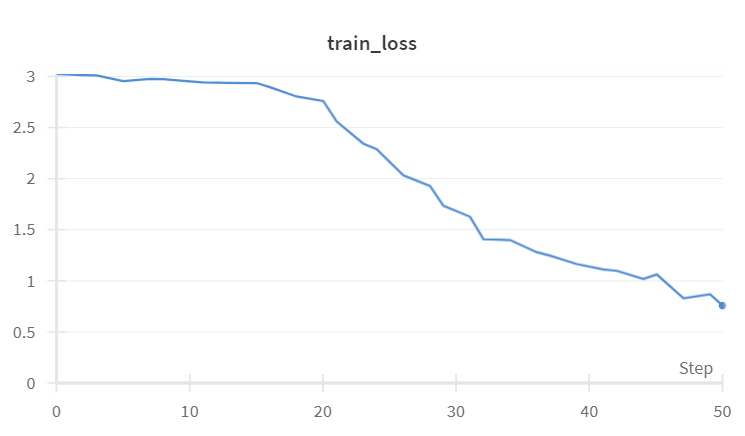

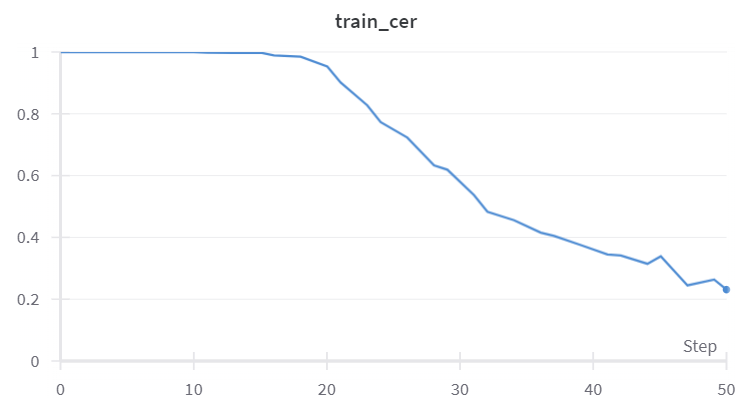

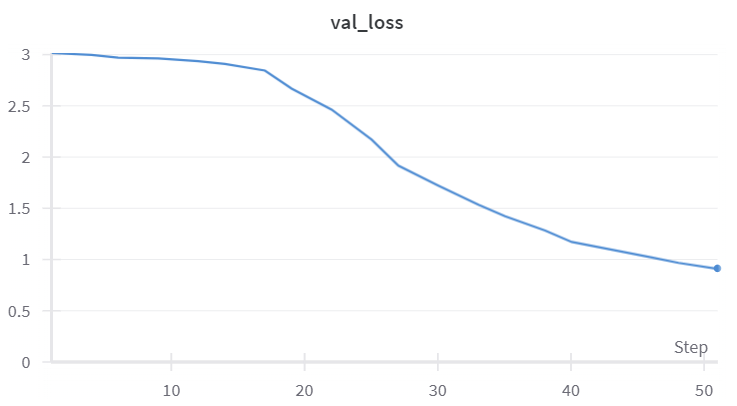

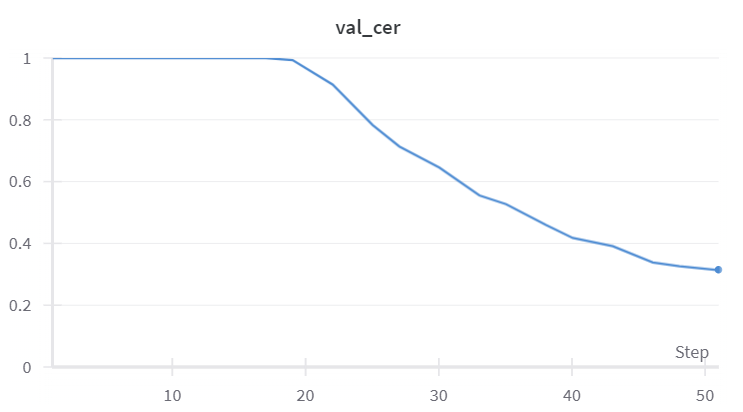

---




**→ Using your plots as evidence in your description, answer the following questions:**

a) What is the model's best test CER?

b) Does the model learn and converge? What do you notice about CTC loss early in training?

c) Does the model overfit? Despite the small dataset size, why might CTC not overfit?



---

**Answer:**

a) 0.3209935128688812

b) Yes, the model converged, and certainly learnd something.
The CTC loss almost doesn't decrease at the begin of the training, it has a distinct drop around 20 steps.

c) I think the model doesn't overfit, and we can see the loss curve still have a decreasing tendency. The reason might be the CTC loss function inherently deals with the alignment problem by allowing the model to learn directly from sequences with different lengths. This enables the model to focus on learning patterns within the data, contributing to better generalization even with a small dataset.

---

# Part 3: Analysis

While looking at validation and test CER is a good way to judge how a model is performing, it is also important to look at specific examples it does well on or fails on, in order to build an intuition for why it fails.

## **Task 3.1: Lowest and Highest CER Examples [5 Points]**

**Implementation & Written Response**

**→ Now we will find and examine a test utterance your model transcribes well and a test utterance it transcribes poorly.** Fill out `get_low_high_cer_wav` to get the lowest and highest CERs and their corresponding utterances in your test set.

In [ ]:
from tqdm import tqdm

def get_low_high_cer_wav(system, device=None):
  """Gets the test set sample with lowest CER and the sample with highest CER.

  Args:
    system: Subclassed LightningModule for your model.
    device: Instance of torch.device(...) [default: None]

  Returns:
    lowest CER (float), audio of the lowest CER utterance (ndarray),
    highest CER (float), audio of the highest CER utterance (ndarray)
  """
  # Init values.
  low_cer = float('inf')
  low_idx = 0
  high_cer = float('-inf')
  high_idx = 0

  test_dataloader = system.test_dataloader()
  index_lookup = system.test_dataset.indices

  pbar = tqdm(total=len(test_dataloader))
  for i, batch in enumerate(test_dataloader):
    input_features, input_lengths = batch[0], batch[1]
    labels, label_lengths = batch[2], batch[3]
    batch_size = input_features.size(0)
    if device is not None:
      input_features = input_features.to(device)
    ############################ START OF YOUR CODE ############################
    # TODO(3.1)
    # Hint:
    # - Use `get_cer_per_sample`, which gets a numpy array of
    #   CERs for each sample in a batch
    # - Use `index_lookup` to map a sample's test set index to
    #   its index in the full dataset.


    log_probs, _ = system(input_features, input_lengths, labels, label_lengths)
    hypotheses, hypothesis_lengths, references, reference_lengths = \
        system.model.decode(log_probs, input_lengths, labels, label_lengths,
            system.test_dataset.sos_index,
            system.test_dataset.eos_index,
            system.test_dataset.pad_index,
            system.test_dataset.eps_index)


    cers = get_cer_per_sample(hypotheses, hypothesis_lengths, references, reference_lengths)

    if np.min(cers) < low_cer:
      low_cer = np.min(cers)
      low_idx = index_lookup[i*batch_size + np.argmin(cers)]
    if np.max(cers) > high_cer:
      high_cer = np.max(cers)
      high_idx = index_lookup[i*batch_size + np.argmax(cers)]

    ############################# END OF YOUR CODE #############################
    pbar.update()
  pbar.close()

  # Retrieve ndarray wav data from the original h5py file.
  system.test_dataset.load_waveforms()
  waveform_data = system.test_dataset.waveform_data
  low_wav = waveform_data[f'{low_idx}'][:]
  high_wav = waveform_data[f'{high_idx}'][:]

  return low_cer, low_wav, high_cer, high_wav

In [ ]:
checkpoint_path = None
############################## START OF YOUR CODE ##############################
# TODO(3.1)
# Add your CTC checkpoint path.

checkpoint_path = '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc/epoch=19-step=1620-v5.ckpt'
############################## END OF YOUR CODE ################################

device = torch.device('cuda')
system = LightningCTC.load_from_checkpoint(checkpoint_path)
system = system.to(device)
system.eval()
low_cer, low_wav, high_cer, high_wav = get_low_high_cer_wav(system, device)


> Constructing HarperValleyBank train dataset...
> Constructing HarperValleyBank val dataset...
> Constructing HarperValleyBank test dataset...


100%|██████████| 23/23 [00:43<00:00,  1.89s/it]


In [ ]:
print('Utterance with lowest CER: {}\n'.format(low_cer))
Audio(low_wav, rate=8000)

Utterance with lowest CER: 0.0



In [ ]:
print('Utterance with highest CER: {}\n'.format(high_cer))
Audio(high_wav, rate=8000)

Utterance with highest CER: 0.9444444444444444



**→ What are the lowest and highest CERs? Why do you think CTC got these CERs for these utterances?**



---

**Answer:**

The lowest cer is 0.0, and the highest is 0.94.

Sentences with the lowest cer have more consecutive readings and are spoken faster, making it difficult even for humans to hear clearly what is being said. And the pronunciation of each word in the sentence with the highest cer is obvious and clear.

---



## **Task 3.2: Run inference using your model [5 points]**

**Implementation**

**→ Similar to `get_low_high_cer_wav`, we'll run inference on a single audio file and see what the model transcribes.** Fill in `run_inference` to have your system decode test utterances from a `.WAV` file. We will later run this function in Parts 5 and 7 to qualitatively evaluate systems.

In [ ]:
def run_inference(
    system, wav, device=None, sr=8000, n_mels=128, n_fft=256, win_length=256,
    hop_length=128, wav_max_length=512, labels=None, label_lengths=None):
  """Run your system on a .WAV file and returns a string utterance.

  Args:
    system: a pl.LightningModule for your chosen model.
    wav: a .WAV file of an utterance
    device: GPU -> torch.device('cuda')

  Returns:
    A string for the utterance transcribed by your model.
  """
  input_feature = None
  ############################# START OF YOUR CODE #############################
  # TODO(3.2)
  # Extract features from the utterance. This is similar to what you implemented
  # in `get_primary_task_data`.
  # Hint:
  # - Make sure to put the extracted features into a batch of size 1.
  melspec = librosa.feature.melspectrogram(
      y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mels=n_mels)
  logmelspec = librosa.power_to_db(melspec, ref=np.max)
  norm_logmelspec = librosa.util.normalize(logmelspec)
  input_feature, input_length = pad_wav(norm_logmelspec.T, wav_max_length)
  input_feature = torch.FloatTensor([input_feature])

  ############################## END OF YOUR CODE ##############################

  input_lengths = torch.LongTensor([input_length])
  # Whether or not to use GPU.
  if device is not None:
    input_feature = input_feature.to(device)
    input_lengths = input_lengths.to(device)
    if labels is not None:  # to test teacher-forcing
      labels = labels.to(device)
      labels_lengths = label_lengths.to(device)

  utterance = None
  ############################# START OF YOUR CODE #############################
  # TODO(3.2)
  # Run your system on the utterance input feature to get log probabilities
  # and decode the log probabilities into indices. Then turn those indices into
  # characters.
  utterance = []
  log_probs, _ = system(input_feature, input_lengths, labels, label_lengths)
  hypotheses, hypothesis_lengths, _, _ = \
      system.model.decode(log_probs, input_lengths, labels, label_lengths,
          system.test_dataset.sos_index,
          system.test_dataset.eos_index,
          system.test_dataset.pad_index,
          system.test_dataset.eps_index)
  full_vocab = ['<eps>', '<sos>', '<eos>', '<pad>'] + VOCAB + SILENT_VOCAB
  for label in hypotheses[0]:
    utterance.append(full_vocab[label])
  utterance = "".join(utterance)

  ############################## END OF YOUR CODE ##############################
  return utterance


In [ ]:
def run_inference(
    system, wav, device=None, sr=8000, n_mels=128, n_fft=256, win_length=256,
    hop_length=128, wav_max_length=512, labels=None, label_lengths=None):
  """Run your system on a .WAV file and returns a string utterance.

  Args:
    system: a pl.LightningModule for your chosen model.
    wav: a .WAV file of an utterance
    device: GPU -> torch.device('cuda')

  Returns:
    A string for the utterance transcribed by your model.
  """
  input_feature = None
  ############################# START OF YOUR CODE #############################
  # TODO(3.2)
  # Extract features from the utterance. This is similar to what you implemented
  # in `get_primary_task_data`.
  # Hint:
  # - Make sure to put the extracted features into a batch of size 1.


  melspec = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mels=n_mels)
  logmelspec = librosa.power_to_db(melspec, ref=np.max)
  norm_logmelspec = librosa.util.normalize(logmelspec)
  input_feature, input_length = pad_wav(norm_logmelspec.T, wav_max_length)
  input_feature = torch.FloatTensor([input_feature])


  ############################## END OF YOUR CODE ##############################

  input_lengths = torch.LongTensor([input_length])
  # Whether or not to use GPU.
  if device is not None:
    input_feature = input_feature.to(device)
    input_lengths = input_lengths.to(device)
    if labels is not None:  # to test teacher-forcing
      labels = labels.to(device)
      labels_lengths = label_lengths.to(device)

  utterance = []
  ############################# START OF YOUR CODE #############################
  # TODO(3.2)
  # Run your system on the utterance input feature to get log probabilities
  # and decode the log probabilities into indices. Then turn those indices into
  # characters.

  log_probs, _ = system(input_feature, input_lengths, labels, label_lengths)
  hypotheses, hypothesis_lengths, _, _ = \
      system.model.decode(log_probs, input_lengths, labels, label_lengths,
          system.test_dataset.sos_index,
          system.test_dataset.eos_index,
          system.test_dataset.pad_index,
          system.test_dataset.eps_index)

  charts = train_dataset.indices_to_chars(hypotheses[0])
  word = ''
  for i in charts:
    if i == ' ':
      utterance.append(word)
      word = ''
    word += i
  utterance.append(word)

  ############################## END OF YOUR CODE ##############################
  return utterance


In [ ]:
index = 20000

w = waveform_data[f'{index}'][:]
t = label_data['human_transcripts'][index]

print('index {}: "{}"\n'.format(index, t))
Audio(w, rate=8000)

utterance = run_inference(
    system, w, device=torch.device('cuda'), sr=8000, n_mels=128, n_fft=256, win_length=256,
    hop_length=128, wav_max_length=512, labels=None, label_lengths=None)

print(utterance)


index 20000: "thank you for calling have a good day"

['thank', ' you', ' for', ' caling', ' have', ' a', ' geat', ' day']


# Part 4: Leveraging Auxiliary Tasks for Multi-Task Learing

When designing a speech system, we might care about more than just the transcription. As a bank, we might want to know the intent of the caller, for example.

Our dataset includes the dialog action, the intent of the caller, and the sentiment of the caller. In the spirit of an end-to-end system, we will expand the CTC model to make predictions for auxiliary tasks. It is up to you which tasks you decide to multi-task on!


## **Task 4.1 Working with auxiliary task data [5 Points]**

**Implementation**

**→ Fill in `__getitem__`. Add one or more auxiliary tasks to your training.** We include `get_auxiliary_labels` for you.

In [ ]:
class HarperValleyBankMTL(HarperValleyBank):
  """Like the HarperValleyBank dataset but returns labels for task type,
  dialog actions, and sentiment: our three auxiliary tasks.

  See `HarperValleyBank` class for description.
  """
  def __init__(
    self, root, split='train', n_mels=128, n_fft=128, win_length=256,
    hop_length=128, wav_max_length=200, transcript_max_length=200,
    append_eos_token=False):
    super().__init__(
      root, split=split, n_mels=n_mels, n_fft=n_fft,
      win_length=win_length, hop_length=hop_length,
      wav_max_length=wav_max_length,
      transcript_max_length=transcript_max_length,
      append_eos_token=append_eos_token)
    self.task_num_labels = None
    self.dialog_num_labels = None
    self.auxiliary_labels = self.get_auxiliary_labels()

  def get_auxiliary_labels(self):
    """Returns auxiliary task labels.

    This function will take the raw auxiliary tasks and convert them
    integers labels (for neural networks).

    These include: `task_type`, `dialogue_acts`, and `sentiment`.
    """
    # task_types: each element is a string representing a conversation-level
    #             label. So all utterances in the same conversation share
    #             the same label.
    task_types = self.label_data['task_types']
    # dialog_acts: each element is a comma-separated string of dialog actions
    #              that describe the current utterance
    dialog_acts = self.label_data['dialog_acts']
    dialog_acts = [acts.split(',') for acts in dialog_acts]
    # sentiments: each element is a 3 dimensional vector that sums to 1
    #             representing the probabilities for
    #             "negative", "neutral", and "positive"
    sentiment_labels = self.label_data['sentiments']

    # Get label vocabularies.
    task_type_vocab = sorted(set(task_types))
    dialog_acts_vocab = sorted(set([item for sublist in dialog_acts
                                    for item in sublist]))

    self.task_num_labels = len(task_type_vocab)
    self.dialog_num_labels = len(dialog_acts_vocab)

    task_type_labels = [task_type_vocab.index(t) for t in task_types]

    # dialog_acts_labels: list of 1-hot vectors
    dialog_acts_labels = []
    for acts in dialog_acts:
      onehot = [0 for _ in range(len(dialog_acts_vocab))]
      for act in acts:
        onehot[dialog_acts_vocab.index(act)] = 1
      dialog_acts_labels.append(onehot)

    # Store number of classes for each auxiliary task.
    # Note:
    #   - task_type is a N-way classification problem.
    #   - dialog_acts is a set of binary classification problems.
    #       (more than one dialog action may be "on" for an utterance)
    #   - sentiment is a regression problem (match given probabilities).
    self.task_type_num_class = len(task_type_vocab)
    self.dialog_acts_num_class = len(dialog_acts_vocab)
    self.sentiment_num_class = 3

    return task_type_labels, dialog_acts_labels, sentiment_labels

  def __getitem__(self, index):
    """Serves multi-task data for a single utterance."""
    if not hasattr(self, 'waveform_data'):
      self.load_waveforms()

    index = int(self.indices[index])

    primary_task_data = self.get_primary_task_data(index)
    auxiliary_task_data = None

    ############################ START OF YOUR CODE ############################
    # TODO(4.1)
    # Get auxiliary task label(s) for this index using
    # `self.auxiliary_task_labels`. Populate the object `auxiliary_task_data`
    # as a tuple of auxiliary task labels. Make sure to cast appropriate
    # torch tensor types for the different labels.

    auxiliary_task_data = (torch.tensor(self.auxiliary_labels[0][index],dtype=int),
    torch.tensor(self.auxiliary_labels[1][index],dtype=int),
    torch.tensor(self.auxiliary_labels[2][index],dtype=float))


    ############################# END OF YOUR CODE #############################
    if not isinstance(auxiliary_task_data, tuple):
      auxiliary_task_data = (auxiliary_task_data,)

    return primary_task_data + auxiliary_task_data


## **Task 4.2: Implement auxiliary task heads [2 points]**

**Implementation**

**→ Fill out the `*Classifier` classes for your multi-tasking design choice.** These classifiers only require a single layer in depth. You will use these in `LightningCTCMTL`.

In [ ]:
class TaskTypeClassifier(nn.Module):
  def __init__(self, input_dim, n_classes):
    super().__init__()
    ############################ START OF YOUR CODE ############################
    # TODO(4.2)
    self.f = torch.nn.Flatten(1)
    self.fc1 = nn.Linear(input_dim, input_dim*2)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(input_dim*2, n_classes)
    ############################# END OF YOUR CODE #############################

  def forward(self, inputs):
    log_probs = None
    ############################ START OF YOUR CODE ############################
    # TODO(4.2)
    # Hint: This is an N-way classification problem.
    out = self.f(inputs.to(torch.float))
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    log_probs = torch.log_softmax(out, dim=1)

    ############################# END OF YOUR CODE #############################
    return log_probs


  def get_loss(self, probs, targets):
    loss = None
    ############################ START OF YOUR CODE ############################
    # TODO(4.2)
    floss = nn.CrossEntropyLoss()
    loss = floss(probs.to(torch.float), targets.to(torch.float))
    ############################# END OF YOUR CODE #############################
    return loss


class DialogActsClassifier(nn.Module):
  def __init__(self, input_dim, n_classes):
    super().__init__()
    ############################ START OF YOUR CODE ############################
    # TODO(4.2)
    self.f = torch.nn.Flatten(1)
    self.fc1 = nn.Linear(input_dim, input_dim*2)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(input_dim*2, n_classes)
    self.softmax = nn.Softmax(dim=1)
    ############################# END OF YOUR CODE #############################

  def forward(self, inputs):
    probs = None
    ############################ START OF YOUR CODE ############################
    # TODO(4.2)
    # Hint: One person can have multiple dialog actions.
    out = self.f(inputs.to(torch.float))
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)

    probs = self.softmax(out)


    ############################# END OF YOUR CODE #############################
    return probs

  def get_loss(self, probs, targets):
    loss = None
    ############################ START OF YOUR CODE ############################
    # TODO(4.2)
    # Hint:
    # - probs shape: (batch_size, num_dialog_acts)
    # - targets shape: (batch_size, num_dialog_acts)
    floss = nn.BCELoss()
    loss = floss(probs.to(torch.float), targets.to(torch.float))
    #loss = torch.mean(torch.tensor([floss(probs[i], targets[i]) for i in len(probs.size[0])]))
    ############################# END OF YOUR CODE #############################
    return loss


class SentimentClassifier(nn.Module):
  def __init__(self, input_dim, n_classes):
    super().__init__()
    ############################ START OF YOUR CODE ############################
    # TODO(4.2)
    self.f = torch.nn.Flatten(1)
    self.fc1 = nn.Linear(input_dim, input_dim*2)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(input_dim*2, n_classes)
    self.softmax = nn.Softmax(dim=1)
    ############################# END OF YOUR CODE #############################

  def forward(self, inputs):
    probs = None
    ############################ START OF YOUR CODE ############################
    # TODO(4.2)
    # Hint:
    # - Sentiment is measured as a log probability distribution among multiple
    #   possible sentiments.
    out = self.f(inputs.to(torch.float))
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    probs = self.softmax(out)
    ############################# END OF YOUR CODE #############################
    return probs

  def get_loss(self, pred_probs, target_probs):
    loss = None
    ############################ START OF YOUR CODE ############################
    # TODO(4.2)
    # Hint:
    # - As usual, the predictions are probabilities. But the labels for
    #   sentiment are themselves probabilities. Since the targets are not be
    #   single numbers, we cannot just use `F.cross_entropy`.
    # - Therefore, you will need to implement cross entropy manually.
    #     Refer to wikipedia: https://en.wikipedia.org/wiki/Cross_entropy
    # - pred_logits shape: (batch_size, num_sentiment_class)
    # - target_logits shape: (batch_size, num_sentiment_class)
    loss = torch.mean(-torch.sum(torch.mul(torch.log(pred_probs), target_probs),dim=1))
    #loss = torch.mean([-torch.sum([torch.log(pred_probs[j,i])*target_probs[j,i] for i in range(pred_probs.size[1])]) for j in range(pred_probs.size[0])])
    ############################# END OF YOUR CODE #############################
    return loss


## **Task 4.3: Implement multi-task learning loss [3 points]**

**Implementation**

**Metrics.** We provide code for computing the metrics for each possible auxiliary task. For task type classification and sentiment classification, you should use accuracy. For dialog acts classification, you should use F1 score (as it is very unbalanced).

**→ Instantiate your auxiliary task models in `__init__` for `LightningCTCMTL` and implement/modify `get_multi_task_loss`.** You can additively combine loss functions and use weighting parameters in your addition to trade off the importance of different tasks during training.

**Note:** In general, your choice of weighting parameters is often an important design decision for your system! It is even possible to negatively weight certain tasks that may otherwise bias the primary task prediction through simple correlation. This turns those auxiliary tasks into adversarial tasks (that your model should *not* do well on) and can lead to more robust performance on certain edge cases.

**Note:** In the Lightning class below, these weights are expressed as `asr_weight`, `task_type_weight`, `dialog_acts_weight`, and `sentiment_weight`. You should choose them to sum to 1.

**→ Modify `validation_epoch_end` and `test_epoch_end`.** Leave in the necessary code to store metrics for your model's auxiliary tasks.

In [ ]:
class LightningCTCMTL(LightningCTC):
  """PyTorch Lightning class for training CTC with multi-task learning."""
  def __init__(self, n_mels=128, n_fft=256, win_length=256, hop_length=128,
               wav_max_length=200, transcript_max_length=200,
               learning_rate=1e-3, batch_size=256, weight_decay=1e-5,
               encoder_num_layers=2, encoder_hidden_dim=256,
               encoder_bidirectional=True, asr_weight=0.4, task_type_weight=0.2,
               dialog_acts_weight=0.2, sentiment_weight=0.2):
    super().__init__(
      n_mels=n_mels, hop_length=hop_length,
      wav_max_length=wav_max_length,
      transcript_max_length=transcript_max_length,
      learning_rate=learning_rate,
      batch_size=batch_size,
      weight_decay=weight_decay,
      encoder_num_layers=encoder_num_layers,
      encoder_hidden_dim=encoder_hidden_dim,
      encoder_bidirectional=encoder_bidirectional)
    self.save_hyperparameters()
    self.asr_weight = asr_weight
    self.task_type_weight = task_type_weight
    self.dialog_acts_weight = dialog_acts_weight
    self.sentiment_weight = sentiment_weight
    self.encoder_num_layers = encoder_num_layers
    self.encoder_bidirectional = encoder_bidirectional

    ############################ START OF YOUR CODE ############################
    # TODO(4.3)
    # Instantiate your auxiliary task models here.

    self.task_type_model, self.dialog_acts_model, self.sentiment_model= self.auxiliary_task_model()


  def auxiliary_task_model(self):

    bidirectional = 1
    if self.encoder_bidirectional:
      bidirectional= 2

    TaskTypeModel = TaskTypeClassifier(2 * self.encoder_hidden_dim * bidirectional * self.encoder_num_layers,self.train_dataset.task_num_labels)
    DialogActsModel = DialogActsClassifier(2 * self.encoder_hidden_dim * bidirectional * self.encoder_num_layers,self.train_dataset.dialog_num_labels)
    SentimentModel = SentimentClassifier(2 * self.encoder_hidden_dim * bidirectional * self.encoder_num_layers,3)

    return TaskTypeModel, DialogActsModel, SentimentModel

    ############################# END OF YOUR CODE #############################

  def create_datasets(self):
    root = os.path.join(DATA_PATH, 'harper_valley_bank_minified')
    train_dataset = HarperValleyBankMTL(
      root, split='train', n_mels=self.n_mels, n_fft=self.n_fft,
      win_length=self.win_length, hop_length=self.hop_length,
      wav_max_length=self.wav_max_length,
      transcript_max_length=self.transcript_max_length,
      append_eos_token=False)
    val_dataset = HarperValleyBankMTL(
      root, split='val', n_mels=self.n_mels, n_fft=self.n_fft,
      win_length=self.win_length, hop_length=self.hop_length,
      wav_max_length=self.wav_max_length,
      transcript_max_length=self.transcript_max_length,
      append_eos_token=False)
    test_dataset = HarperValleyBankMTL(
      root, split='test', n_mels=self.n_mels, n_fft=self.n_fft,
      win_length=self.win_length, hop_length=self.hop_length,
      wav_max_length=self.wav_max_length,
      transcript_max_length=self.transcript_max_length,
      append_eos_token=False)
    return train_dataset, val_dataset, test_dataset

  def get_multi_task_loss(self, batch, split='train'):
    """Gets losses and metrics for all task heads."""
    # Compute loss on the primary ASR task.
    asr_loss, asr_metrics, embedding = self.get_primary_task_loss(batch[:4], split)

    # Note: Not all of these have to be used (it is up to your design)
    task_type_labels = None
    dialog_acts_labels = None
    sentiment_labels = None
    task_type_log_probs = None
    dialog_acts_probs = None
    sentiment_log_probs = None
    task_type_loss = None
    dialog_acts_loss = None
    sentiment_loss = None
    combined_loss = None
    ############################ START OF YOUR CODE ############################
    # TODO(4.3)
    # Implement multi-task learning by combining multiple objectives.
    # Define `combined_loss` here.

    task_type_labels, dialog_acts_labels, sentiment_labels = batch[4], batch[5], batch[6]

    task_type_log_probs = self.task_type_model(embedding)
    dialog_acts_probs = self.dialog_acts_model(embedding)
    sentiment_log_probs = self.sentiment_model(embedding)

    task_type_preds = torch.argmax(task_type_log_probs, dim=1)

    task_type_loss = self.task_type_model.get_loss(task_type_preds, task_type_labels)

    dialog_acts_loss = self.dialog_acts_model.get_loss(dialog_acts_probs, dialog_acts_labels)

    sentiment_loss = self.sentiment_model.get_loss(sentiment_log_probs, sentiment_labels)

    combined_loss = self.asr_weight*asr_loss + self.task_type_weight*task_type_loss + self.dialog_acts_weight*dialog_acts_loss + self.sentiment_weight*sentiment_loss

    ############################ END OF YOUR CODE ##############################

    with torch.no_grad():
      ############################ START OF YOUR CODE ##########################
      # TODO(4.3)
      # No additional code is required here. :)
      # We provide how to compute metrics for all possible auxiliary tasks and
      # store them in your metrics dictionary. Comment out the metrics for tasks
      # you do not plan to use.

      # TASK_TYPE: Compare predicted task type to true task type.

      task_type_acc = \
        (task_type_preds == task_type_labels).float().mean().item()

      # DIALOG_ACTS: Compare predicted dialog actions to true dialog actions.
      dialog_acts_preds = torch.round(dialog_acts_probs)
      dialog_acts_f1 = f1_score(dialog_acts_labels.cpu().numpy().reshape(-1),
                                dialog_acts_preds.cpu().numpy().reshape(-1))


      # SENTIMENT: Compare largest predicted sentiment to largest true sentim
      sentiment_preds = torch.argmax(sentiment_log_probs, dim=1)
      sentiment_labels = torch.argmax(sentiment_labels, dim=1)
      sentiment_acc = \
      (sentiment_preds == sentiment_labels).float().mean().item()

      metrics = {
        # Task losses.
        f'{split}_asr_loss': asr_metrics[f'{split}_loss'],
        f'{split}_task_type_loss': task_type_loss,
        f'{split}_dialog_acts_loss': dialog_acts_loss,
        f'{split}_sentiment_loss': sentiment_loss,
        # CER as ASR metric.
        f'{split}_asr_cer': asr_metrics[f'{split}_cer'],
        # Accuracy as task_type metric.
        f'{split}_task_type_acc': task_type_acc,
        # F1 score as dialog_acts metric.
        f'{split}_dialog_acts_f1': dialog_acts_f1,
        # Accuracy as sentiment metric.
        f'{split}_sentiment_acc': sentiment_acc
      }
      ############################ END OF YOUR CODE ############################
    return combined_loss, metrics

  # comment out parameters for the models you don't use
  def configure_optimizers(self):
    parameters = chain(self.model.parameters(),
                       self.task_type_model.parameters(),
                       self.dialog_acts_model.parameters(),
                       self.sentiment_model.parameters())
    optim = torch.optim.AdamW(parameters, lr=self.lr,
                              weight_decay=self.weight_decay)
    return [optim], []

  def training_step(self, batch, batch_idx):
    loss, metrics = self.get_multi_task_loss(batch, split='train')
    self.log_dict(metrics)
    # self.log('train_asr_loss', metrics['train_asr_loss'], prog_bar=True,
    #          on_step=True)
    # self.log('train_asr_cer', metrics['train_asr_cer'], prog_bar=True,
    #          on_step=True)
    return loss

  def validation_step(self, batch, batch_idx):
    loss, metrics = self.get_multi_task_loss(batch, split='val')
    return metrics

  def validation_epoch_end(self, outputs):
    ############################ START OF YOUR CODE ############################
    # TODO(4.3)
    # No additional code is required here. :)
    # Comment out the metrics for tasks you do not plan to use.
    metrics = {
      'val_asr_loss': torch.tensor([elem['val_asr_loss']
                                    for elem in outputs]).float().mean(),
      'val_asr_cer': torch.tensor([elem['val_asr_cer']
                                   for elem in outputs]).float().mean(),
      'val_task_type_loss': torch.tensor([elem['val_task_type_loss']
                                          for elem in outputs]).float().mean(),
      'val_task_type_acc': torch.tensor([elem['val_task_type_acc']
                                          for elem in outputs]).float().mean(),
      'val_dialog_acts_loss': torch.tensor([elem['val_dialog_acts_loss']
                                            for elem in outputs]).float().mean(),
      'val_dialog_acts_f1': torch.tensor([elem['val_dialog_acts_f1']
                                          for elem in outputs]).float().mean(),
      'val_sentiment_loss': torch.tensor([elem['val_sentiment_loss']
                                          for elem in outputs]).float().mean(),
      'val_sentiment_acc': torch.tensor([elem['val_sentiment_acc']
                                         for elem in outputs]).float().mean()
      }
    ############################# END OF YOUR CODE #############################
    # self.log('val_asr_loss', metrics['val_asr_loss'], prog_bar=True)
    # self.log('val_asr_cer', metrics['val_asr_cer'], prog_bar=True)
    self.log_dict(metrics)

  def test_step(self, batch, batch_idx):
    loss, metrics = self.get_multi_task_loss(batch, split='test')
    return metrics

  def test_epoch_end(self, outputs):
    ############################ START OF YOUR CODE ############################
    # TODO(4.3)
    # No additional code is required here. :)
    # Comment out the metrics for tasks you do not plan to use.
    metrics = {
      'test_asr_loss': torch.tensor([elem['test_asr_loss']
                                    for elem in outputs]).float().mean(),
      'test_asr_cer': torch.tensor([elem['test_asr_cer']
                                   for elem in outputs]).float().mean(),
      'test_task_type_loss': torch.tensor([elem['test_task_type_loss']
                                          for elem in outputs]).float().mean(),
      'test_task_type_acc': torch.tensor([elem['test_task_type_acc']
                                          for elem in outputs]).float().mean(),
      'test_dialog_acts_loss': torch.tensor([elem['test_dialog_acts_loss']
                                             for elem in outputs]).float().mean(),
      'test_dialog_acts_f1': torch.tensor([elem['test_dialog_acts_f1']
                                           for elem in outputs]).float().mean(),
      'test_sentiment_loss': torch.tensor([elem['test_sentiment_loss']
                                           for elem in outputs]).float().mean(),
      'test_sentiment_acc': torch.tensor([elem['test_sentiment_acc']
                                          for elem in outputs]).float().mean()
      }
    ############################# END OF YOUR CODE #############################
    # self.log('test_asr_loss', metrics['test_asr_loss'], prog_bar=True)
    # self.log('test_asr_cer', metrics['test_asr_cer'], prog_bar=True)
    self.log_dict(metrics)


## **Task 4.1: Training CTC-MTL [10 points]**

**Training & Written Response**

**→ Train the CTC-MTL network with the default hyperparameters we provide.**

One epoch of training CTC-MTL takes 3 minutes. We recommend to train for at least 15-20 epochs, although we do not guarantee this is enough to converge. If your notebook resets, you can continue training from an old checkpoint.

**NOTE: We expect this model to perform a bit worse on CER compared with the CTC-only objective. That's a trade-off when building multi-task learning approaches, so don't spend extra times trying to improve your CER for this question**

**→ Paste screenshots from your Weights & Biases dashboard of your loss curves and CER curve in the cell marked "Plots". Remember to include learning curves for the auxiliary tasks!**

In [ ]:
# Run CTC-MTL

config = {
  'n_mels': 128,
  'n_fft': 256,
  'win_length': 256,
  'hop_length': 128,
  'wav_max_length': 512,
  'transcript_max_length': 200,
  'learning_rate': 1e-3,
  'batch_size': 128,
  'weight_decay': 0,
  'encoder_num_layers': 2,
  'encoder_hidden_dim': 256,
  'encoder_bidirectional': True,
  # you may wish to play with these weights; try to keep the sum
  # of them equal to one.
  'asr_weight': 0.25,
  'task_type_weight': 0.25,
  'dialog_acts_weight': 0.25,
  'sentiment_weight': 0.25,
}

run(system="LightningCTCMTL", config=config, ckpt_dir='ctc_mtl', epochs=20,
    monitor_key='val_asr_loss', use_gpu=True)

> Constructing HarperValleyBank train dataset...
> Constructing HarperValleyBank val dataset...
> Constructing HarperValleyBank test dataset...


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES:

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 81: 'val_asr_loss' reached 3.01506 (best 3.01506), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=0-step=81.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 162: 'val_asr_loss' reached 2.99732 (best 2.99732), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=1-step=162.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 243: 'val_asr_loss' reached 2.97401 (best 2.97401), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=2-step=243.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 324: 'val_asr_loss' reached 2.94016 (best 2.94016), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=3-step=324.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 405: 'val_asr_loss' reached 2.86016 (best 2.86016), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=4-step=405.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 486: 'val_asr_loss' reached 2.69584 (best 2.69584), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=5-step=486.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 567: 'val_asr_loss' reached 2.38670 (best 2.38670), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=6-step=567.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 648: 'val_asr_loss' reached 2.07258 (best 2.07258), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=7-step=648.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 729: 'val_asr_loss' reached 1.85978 (best 1.85978), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=8-step=729.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 810: 'val_asr_loss' reached 1.64709 (best 1.64709), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=9-step=810.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 891: 'val_asr_loss' reached 1.46272 (best 1.46272), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=10-step=891.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 972: 'val_asr_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 1053: 'val_asr_loss' reached 1.25130 (best 1.25130), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=12-step=1053.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 1134: 'val_asr_loss' reached 1.12194 (best 1.12194), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=13-step=1134.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 1215: 'val_asr_loss' reached 1.03076 (best 1.03076), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=14-step=1215.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 1296: 'val_asr_loss' reached 0.99655 (best 0.99655), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=15-step=1296.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 1377: 'val_asr_loss' reached 0.96161 (best 0.96161), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=16-step=1377.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 1458: 'val_asr_loss' reached 0.91642 (best 0.91642), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=17-step=1458.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 1539: 'val_asr_loss' reached 0.86091 (best 0.86091), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=18-step=1539.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1620: 'val_asr_loss' reached 0.82574 (best 0.82574), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=19-step=1620.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=19-step=1620.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INF

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_asr_cer        │    0.28744253516197205    │
│       test_asr_loss       │    0.9035981893539429     │
│    test_dialog_acts_f1    │    0.5466543436050415     │
│   test_dialog_acts_loss   │    0.15589331090450287    │
│    test_sentiment_acc     │    0.8671517372131348     │
│    test_sentiment_loss    │    0.9207121729850769     │
│    test_task_type_acc     │    0.10202731192111969    │
│    test_task_type_loss    │     3408.12744140625      │
└───────────────────────────┴───────────────────────────┘

In [ ]:
# You can find the saved checkpoint here:
!ls /content/cs224s_spring2022/trained_models/ctc_mtl

---

**Plots:**


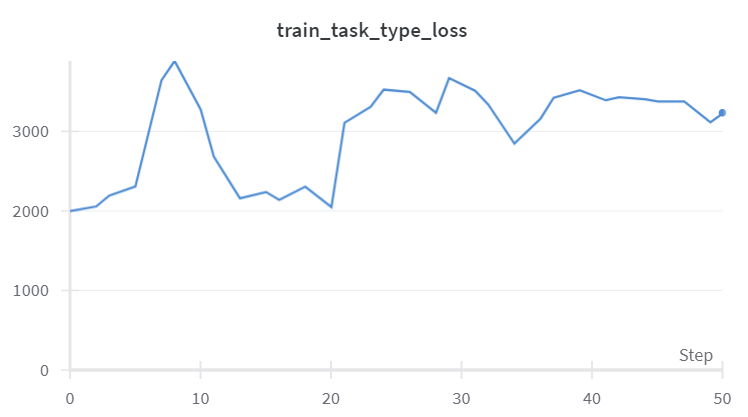

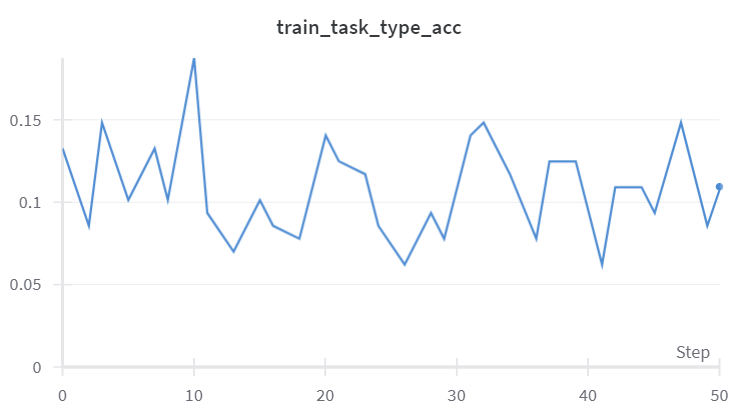

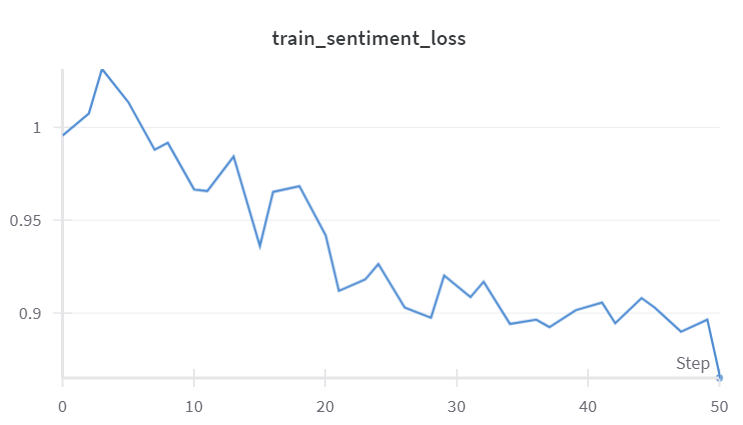

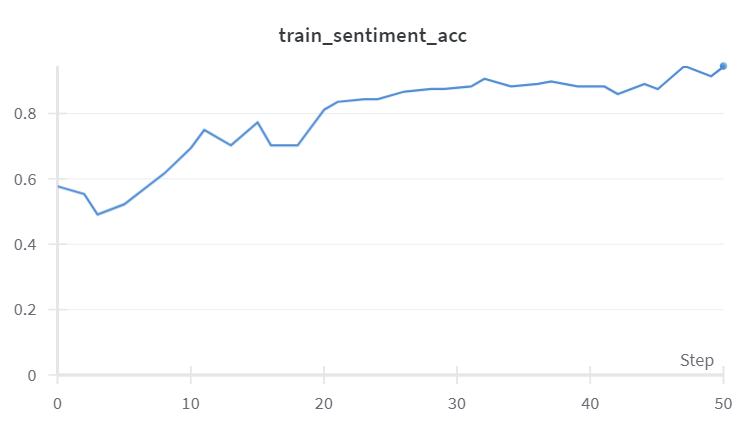

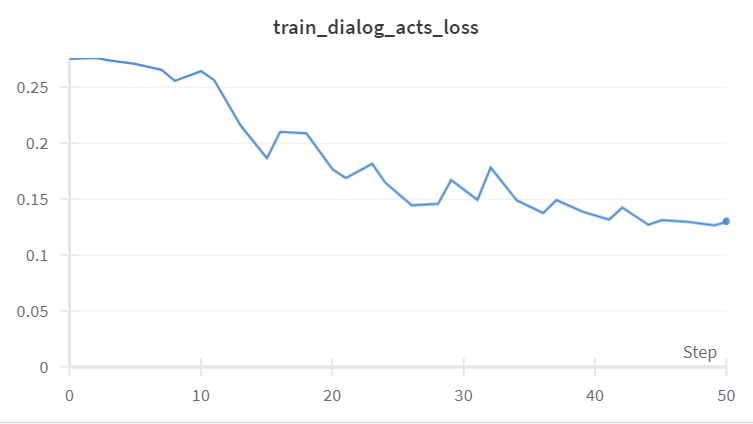

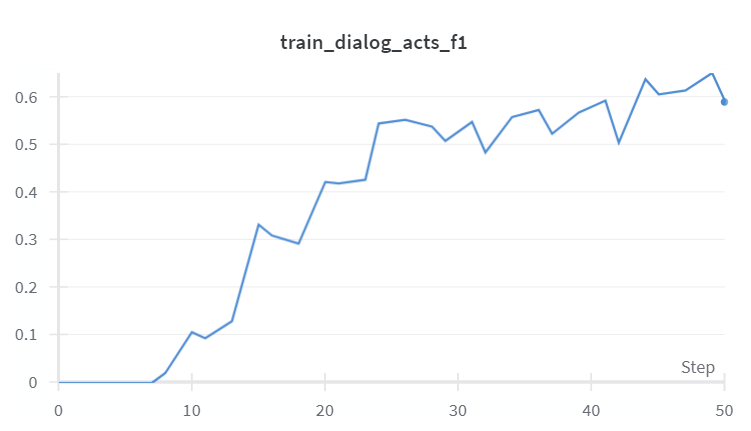

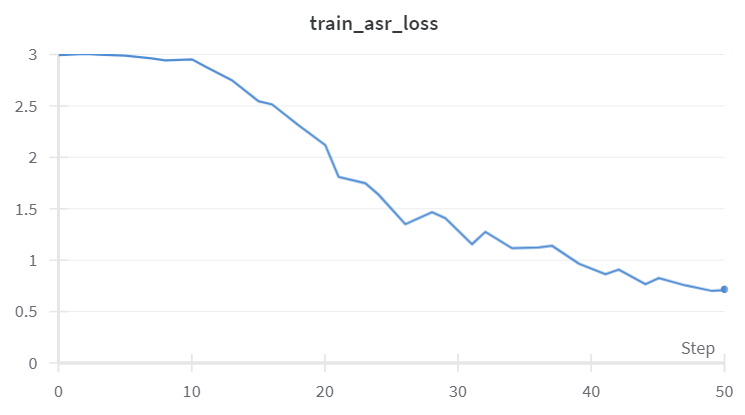

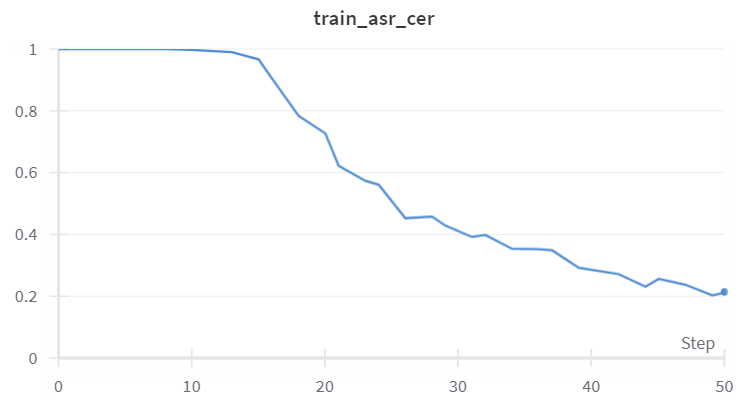

---

**→ Using your plots as evidence in your description, answer the following questions:**

a) Report performance metrics on each of the auxiliary tasks and the CER of your jointly trained model.

b) Under the same configuration of hyperparameters, does CTC-MTL perform better than CTC? Why or why not? (Hint: Have the loss plots converged? How does multi-tasking affect the speed of learning the primary task?)

c) Which tasks seem to be more difficult than others? Why might that be?




---

**Answer:**

a) Test_cer of asr task is 0.28744253516197205, ACC of task type is 0.10, F1 of dialog acts is 0.546 and ACC of sentiment is 0.867.

b) Yes, CTC-MTL perform better than CTC. In the multi-tasks training, the test_cer of asr task becomes much lower, comparing to the single asr task before. Maybe the learning of auxiliary tasks helped the asr task。Perhaps the learning of auxiliary tasks has increased the difficulty of convergence of the ASR task, and the fluctuation of the loss curve has become more obvious, but it has not significantly slowed down the loss convergence speed.

c) Task-type task and Dialog-acts task seem to be more difficult than others. I think it is because the model can not learn the very high-level information very well, so it has a bad performance when the number of the classsification increased.

---



# Part 5: Joint CTC-Attention Based Neural Network
As a practictioner, in designing a speech system you might face the choice between using CTC or LAS, and you might wonder, **why not both**? Now, we'll use even more multi-tasking to improve our performance, except with a twist: we want to regularize our attention-based network to respect CTC alignments. Essentially, we will use CTC as another auxiliary task to aid alignment for recognizing speech, based on this [paper](https://arxiv.org/pdf/1609.06773.pdf) (Kim et al.).





## CTC-Attention understanding check

**Read through the paper. Let us call the proposed model CTC-LAS-MTL.**

**You do not need to submit responses for the questions below. Use these to check your understanding as you work**

a) What is a key advantage of CTC-LAS-MTL over LAS-MTL?


b) What is an erroneous example utterance LAS-MTL might predict that CTC-LAS-MTL would probably not? Explain your reasoning. (Hint: Why might conditional independence sometimes be a good thing?)


c) Describe a tradeoff of weighting the CTC loss higher than the LAS loss vs. lower than the LAS loss.


In [ ]:
class CTCDecoder(nn.Module):
  """
  This is a small decoder (just one linear layer) that takes
  the listener embedding from LAS and imposes a CTC
  objective on the decoding.

  NOTE: This is only to be used for the Joint CTC-Attention model.
  """
  def __init__(self, listener_hidden_dim, num_class, dropout=0.5):
    super().__init__()
    self.fc = nn.Linear(listener_hidden_dim, num_class)
    self.dropout = nn.Dropout(dropout)
    self.listener_hidden_dim = listener_hidden_dim
    self.num_class = num_class

  def forward(self, listener_outputs):
    batch_size, maxlen, _ = listener_outputs.size()
    logits = self.fc(self.dropout(listener_outputs))
    logits = logits.view(batch_size, maxlen, self.num_class)
    log_probs = F.log_softmax(logits, dim=2)
    return log_probs

  def get_loss(
      self, log_probs, input_lengths, labels, label_lengths, blank=0):
    return get_ctc_loss(
      log_probs, labels, input_lengths, label_lengths, blank)

## **Task 5.1: CTC-LAS Network [5 points]**

**→ Read through the starter code and fill out the `forward` pass for `JointCTCAttention`.**

## **Task 5.2: Training CTC-LAS-MTL [10 points]**

**Training results & written response**

**→ Train the CTC-LAS-MTL network with the default hyperparameters we provide.**

Like LAS-MTL, this model takes 6-7 minutes per epoch to train. We recommend to train for at least 15-20 epochs, although we do not guarantee this is enough to converge. If your notebook resets, you can continue training from an old checkpoint.

**We encourage you to try and tune the model to improve overall task performance or CER. Report your findings if you experiment**

**→ Paste screenshots from your Weights & Biases dashboard of your loss curves and CER curve in the cell marked "Plots". Remember to include learning curves for the auxiliary tasks!**

In [ ]:
# Run Joint CTC/LAS-MTL

config = {
  'n_mels': 128,
  'n_fft': 256,
  'win_length': 256,
  'hop_length': 128,
  'wav_max_length': 512,
  'transcript_max_length': 200,
  'learning_rate': 4e-3,
  'batch_size': 128,
  'weight_decay': 0,
  'encoder_num_layers': 2,    # can't shrink output too much...
  'encoder_hidden_dim': 64,
  'encoder_bidirectional': True,
  'encoder_dropout': 0,
  'decoder_hidden_dim': 128,  # must be 2 x encoder_hidden_dim
  'decoder_num_layers': 1,
  'decoder_multi_head': 1,
  'decoder_mlp_dim': 64,
  'asr_label_smooth': 0.1,
  'teacher_force_prob': 0.9,
  # you may wish to play with these weights; try to keep the sum
  # of them equal to one.
  'ctc_weight': 0.5,  # equal weight between ctc and las?
  'asr_weight': 0.25,
  'task_type_weight': 0.25,
  'dialog_acts_weight': 0.25,
  'sentiment_weight': 0.25,
}

run(system="LightningCTCLASMTL", config=config, epochs=20,
    ckpt_dir='ctc_las_mtl', monitor_key='val_asr_loss', use_gpu=True)


In [ ]:
# You can find the saved checkpoint here:
!ls /content/cs224s_spring2022/trained_models/ctc_las_mtl

---

**Plots:**


---

**→ Using your plots as evidence in your description, answer the following questions:**

a) Report performance metrics on each of the auxiliary tasks and the CER of your jointly trained model.

b) Is your best CER lower than from LAS-MTL?

c) What effects do you observe CTC has on LAS in terms of its learning curve? (e.g. How does the speed of learning compare to that of LAS? In what ways could CTC be improving LAS? Please explain thoroughly.)




---

**Answer:**

cann't run

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

---

In [ ]:
class JointCTCAttention(LASEncoderDecoder):
  """Joint CTC and LAS model that optimizes the LAS objective but
  regularized by the conditional independence of a CTC decoder. One
  can interpret CTC as regularizer on LAS.
  """

  def __init__(
      self, input_dim, num_class, label_maxlen, listener_hidden_dim=128,
      listener_bidirectional=True, num_pyramid_layers=3, dropout=0,
      speller_hidden_dim=256, speller_num_layers=1, mlp_hidden_dim=128,
      multi_head=1, sos_index=0, sample_decode=False):
    super().__init__(
      input_dim,
      num_class,
      label_maxlen,
      listener_hidden_dim=listener_hidden_dim,
      listener_bidirectional=listener_bidirectional,
      num_pyramid_layers=num_pyramid_layers,
      dropout=dropout,
      speller_hidden_dim=speller_hidden_dim,
      speller_num_layers=speller_num_layers,
      mlp_hidden_dim=mlp_hidden_dim,
      multi_head=multi_head,
      sos_index=sos_index,
      sample_decode=sample_decode,
    )
    self.ctc_decoder = CTCDecoder(listener_hidden_dim * 2, num_class)
    self.num_pyramid_layers = num_pyramid_layers
    self.embedding_dim = listener_hidden_dim * 4

  def forward(
      self, inputs, ground_truth=None, teacher_force_prob=0.9,):
    ctc_log_probs = None
    las_log_probs = None
    h, c = None, None
    ############################ START OF YOUR CODE ############################
    # TODO(5.1)
    # Hint:
    # - Encode the inputs with the `listener` network and decode
    #   transcription probabilities using both the `speller` network
    #   and CTCDecoder network.
    log_probs, (h, c) = self.listener(inputs.to(torch.float))

    las_log_probs = self.speller(log_probs)

    ctc_log_probs  = self.ctc_decoder(log_probs)

    ############################# END OF YOUR CODE #############################
    listener_hc = self.combine_h_and_c(h, c)
    return ctc_log_probs, las_log_probs, listener_hc

  def get_loss(
      self, ctc_log_probs, las_log_probs, input_lengths, labels, label_lengths,
      num_labels, pad_index=0, blank_index=0, label_smooth=0.1):
    ctc_loss = self.ctc_decoder.get_loss(
      ctc_log_probs,
      # pyramid encode cuts timesteps in 1/2 each way
      input_lengths // (2**self.num_pyramid_layers),
      labels,
      label_lengths,
      blank=blank_index,
    )
    las_loss = super().get_loss(las_log_probs, labels, num_labels,
                                pad_index=pad_index, label_smooth=label_smooth)

    return ctc_loss, las_loss

  def decode(self, log_probs, input_lengths, labels, label_lengths,
             sos_index, eos_index, pad_index, eps_index):
    las_log_probs = log_probs[1]
    return super().decode(las_log_probs, input_lengths, labels, label_lengths,
                          sos_index, eos_index, pad_index, eps_index)

In [ ]:
class LightningCTCLASMTL(LightningLASMTL):

  def __init__(self, n_mels=128, n_fft=256, win_length=256, hop_length=128,
               wav_max_length=200, transcript_max_length=200,
               learning_rate=1e-3, batch_size=256, weight_decay=1e-5,
               encoder_num_layers=2, encoder_hidden_dim=256,
               encoder_bidirectional=True, encoder_dropout=0,
               decoder_hidden_dim=256, decoder_num_layers=1,
               decoder_multi_head=1, decoder_mlp_dim=128,
               asr_label_smooth=0.1, teacher_force_prob=0.9,
               ctc_weight=0.5, asr_weight=1.0, task_type_weight=1.0,
               dialog_acts_weight=1.0, sentiment_weight=1.0):
    super().__init__(
      n_mels=n_mels,
      n_fft=n_fft,
      win_length=win_length,
      hop_length=hop_length,
      wav_max_length=wav_max_length,
      transcript_max_length=transcript_max_length,
      learning_rate=learning_rate,
      batch_size=batch_size,
      weight_decay=weight_decay,
      encoder_num_layers=encoder_num_layers,
      encoder_hidden_dim=encoder_hidden_dim,
      encoder_bidirectional=encoder_bidirectional,
      encoder_dropout=encoder_dropout,
      decoder_hidden_dim=decoder_hidden_dim,
      decoder_num_layers=decoder_num_layers,
      decoder_multi_head=decoder_multi_head,
      decoder_mlp_dim=decoder_mlp_dim,
      asr_label_smooth=asr_label_smooth,
      teacher_force_prob=teacher_force_prob,
      asr_weight=asr_weight,
      task_type_weight=task_type_weight,
      dialog_acts_weight=dialog_acts_weight,
      sentiment_weight=sentiment_weight)
    self.save_hyperparameters()
    self.ctc_weight = ctc_weight

  def create_model(self):
    model = JointCTCAttention(
      self.train_dataset.input_dim,
      self.train_dataset.num_class,
      self.transcript_max_length,
      listener_hidden_dim=self.encoder_hidden_dim,
      listener_bidirectional=self.encoder_bidirectional,
      num_pyramid_layers=self.encoder_num_layers,
      dropout=self.encoder_dropout,
      speller_hidden_dim=self.decoder_hidden_dim,
      speller_num_layers=self.decoder_num_layers,
      mlp_hidden_dim=self.decoder_mlp_dim,
      multi_head=self.decoder_multi_head,
      sos_index=self.train_dataset.sos_index,
      sample_decode=False)

    return model

  def forward(self, inputs, input_lengths, labels, label_lengths):
    ctc_log_probs, las_log_probs, embedding = self.model(
      inputs,
      ground_truth=labels,
      teacher_force_prob=self.teacher_force_prob)
    return (ctc_log_probs, las_log_probs), embedding

  def get_loss(self, log_probs, input_lengths, labels, label_lengths):
    (ctc_log_probs, las_log_probs) = log_probs
    ctc_loss, las_loss = self.model.get_loss(
      ctc_log_probs,
      las_log_probs,
      input_lengths,
      labels,
      label_lengths,
      self.train_dataset.num_labels,
      pad_index=self.train_dataset.pad_index,
      blank_index=self.train_dataset.eps_index,
      label_smooth=self.asr_label_smooth)
    loss = self.ctc_weight * ctc_loss + (1 - self.ctc_weight) * las_loss
    return loss

# Part 6: One Model to Hear Them All
Congratulations, by this point you have trained multiple end-to-end deep learning neural networks for automatic speech recognition!


## **Task 6.1: Train and summarize your best model [5 Points]**

**Training & Written Response**

**Note:** You are welcome to conduct additional experiments in this part. Please copy cells from above into Part 7 of the notebook if you wish to utilize them.

**→ Alter any model of your choice or training procedure to improve performance! Describe what you tried, and report performance of your best model.** Include in your answer your design choices of:
- Type of neural network (CTC, LAS, or Joint CTC-Attention)
- Any auxiliary task(s) and weighting of tasks you may have used
- Training hyperparameters (e.g. learning rate)

You should attempt to improve your model performance in a reasonable way given what you have observed so far. You do not need to exhaustively optimize performance though; training at least 2 new models with adjustments is enough to obtain full credit for the homework.


---

**Answer:**

use CTC-MTL Network

use task_type, dialog_acts, sentiment tasks, and the weights are: 0.4,0.2,0.2,0.2 respectively.

learning_rate=1e-3, other hyperparameters keep the same

Equal attention was given to four different tasks previously. Now I increase the weight of asr task and decrease them of auxiliary tasks. And I get the asr_cer reduced from 0.2874 to 0.2856.

---



In [ ]:
# Run CTC-MTL

config = {
  'n_mels': 128,
  'n_fft': 256,
  'win_length': 256,
  'hop_length': 128,
  'wav_max_length': 512,
  'transcript_max_length': 200,
  'learning_rate': 1e-3,
  'batch_size': 128,
  'weight_decay': 0,
  'encoder_num_layers': 2,
  'encoder_hidden_dim': 256,
  'encoder_bidirectional': True,
  # you may wish to play with these weights; try to keep the sum
  # of them equal to one.
  'asr_weight': 0.4,
  'task_type_weight': 0.2,
  'dialog_acts_weight': 0.2,
  'sentiment_weight': 0.2,
}

run(system="LightningCTCMTL", config=config, ckpt_dir='ctc_mtl', epochs=20,
    monitor_key='val_asr_loss', use_gpu=True)

> Constructing HarperValleyBank train dataset...
> Constructing HarperValleyBank val dataset...
> Constructing HarperValleyBank test dataset...


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_chec

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 81: 'val_asr_loss' reached 3.01597 (best 3.01597), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=0-step=81.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 162: 'val_asr_loss' reached 2.99805 (best 2.99805), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=1-step=162.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 243: 'val_asr_loss' reached 2.96927 (best 2.96927), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=2-step=243.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 324: 'val_asr_loss' reached 2.93817 (best 2.93817), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=3-step=324.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 405: 'val_asr_loss' reached 2.88864 (best 2.88864), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=4-step=405.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 486: 'val_asr_loss' reached 2.75695 (best 2.75695), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=5-step=486.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 567: 'val_asr_loss' reached 2.47343 (best 2.47343), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=6-step=567.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 648: 'val_asr_loss' reached 2.13788 (best 2.13788), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=7-step=648.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 729: 'val_asr_loss' reached 1.82746 (best 1.82746), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=8-step=729.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 810: 'val_asr_loss' reached 1.61792 (best 1.61792), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=9-step=810.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 891: 'val_asr_loss' reached 1.48610 (best 1.48610), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=10-step=891.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 972: 'val_asr_loss' reached 1.31418 (best 1.31418), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=11-step=972.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 1053: 'val_asr_loss' reached 1.19270 (best 1.19270), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=12-step=1053.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 1134: 'val_asr_loss' reached 1.07140 (best 1.07140), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=13-step=1134.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 1215: 'val_asr_loss' reached 1.04360 (best 1.04360), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=14-step=1215.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 1296: 'val_asr_loss' reached 0.95698 (best 0.95698), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=15-step=1296.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 1377: 'val_asr_loss' reached 0.91585 (best 0.91585), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=16-step=1377.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 1458: 'val_asr_loss' reached 0.85095 (best 0.85095), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=17-step=1458.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 1539: 'val_asr_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 1620: 'val_asr_loss' reached 0.79692 (best 0.79692), saving model to '/content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=19-step=1620-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/gdrive/My Drive/cs224s_spring2022/trained_models/ctc_mtl/epoch=19-step=1620-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_asr_cer        │     0.285631000995636     │
│       test_asr_loss       │    0.8970978856086731     │
│    test_dialog_acts_f1    │    0.5232341885566711     │
│   test_dialog_acts_loss   │    0.15563125908374786    │
│    test_sentiment_acc     │    0.8534396886825562     │
│    test_sentiment_loss    │    0.9229425191879272     │
│    test_task_type_acc     │    0.09341032803058624    │
│    test_task_type_loss    │     3197.57275390625      │
└───────────────────────────┴───────────────────────────┘

# Submission

**Great work!** You have completed the final assignment of the course, and in doing so you have trained deep acoustic models from scratch on a speech dataset, and built intuition for different architectures and design choices for jointly training ASR along with other tasks.

**Gradescope Submission**
- Download your Colab notebook **with all cells fully executed** as a `.ipynb` file. Zip together your `.ipynb` with any supporting files. Submit this zipped file under `Assignment 3: Code Submission`.
- Open your `.ipynb` file locally and save it as a PDF. Submit this PDF under `Assignment 3: PDF Submission` and **tag all pages corresponding to each task**.

# Optional: Testing Your System!

**You can test your system with your own voice samples! Make 2 short recordings of yourself: 1) one on any topic and 2) another on a topic that more closely matches utterances in the HarperValleyBank dataset.** Save/convert them as `.WAV` files and upload them to your `DATA_PATH` directory. Then use `run_inference` to get your best model's transcriptions on them.

- How does it do? Are the transcripts accurate?
- Does the model generalize? If not, why do you think that is? What changes could be made to help the model generalize better?

---

**Answer:**


---

In [ ]:
# Load your saved model weights.

system = None
wav = None
device = torch.device('cuda')
sr = 8000
############################## START OF YOUR CODE ##############################
# TODO(7.2)
# Use system.eval() after you load your PyTorch Lightning system weights.
# Use `librosa.load` (refer to https://librosa.org/doc/latest/index.html).
# Use the default target sample rate of 8000.
# Use `librosa.effects.trim` to remove leading and trailing silences.

############################### END OF YOUR CODE ###############################

run_inference(system, wav, device=device, sr=sr)

# Optional: Listen, Attend and Spell (LAS) Neural Network

This is a stand alone LAS model for the dataset. It tends to overfit on the small HVB training set. You do not need this code for the homework, we leave the LAS section here as a reference for you.

This experiment uses an attention-based encoder-decoder model from the paper [Listen, Attend and Spell](https://arxiv.org/pdf/1508.01211.pdf) (Chan et al.).

## LAS check for understanding

**→ Read through the paper. Think about the following questions:**

a) What is a key advantage of LAS over CTC?


b) How does LAS handle words it may not have seen during training?


c) **Teacher forcing** is a term used to describe a training technique where an RNN feeds the previous time step ground truth as the current time step input. In LAS, when is teacher forcing used and how often? What are some possible downsides to teacher forcing?





## LAS Network
Implementation below

In [ ]:
from utils import (reshape_and_apply, label_smooth_loss)


class Listener(nn.Module):
  """Stacks 3 layers of PyramidLSTMLayers to reduce resolution 8 times.

  Args:
    input_dim: Number of input features.
    hidden_dim: Number of hidden features.
    num_pyramid_layers: Number of stacked lstm layers. (default: 3)
    dropout: Dropout probability. (default: 0)
  """
  def __init__(
      self, input_dim, hidden_dim, num_pyramid_layers=3, dropout=0.,
      bidirectional=True):
    super().__init__()
    self.rnn_layer0 = PyramidLSTMLayer(input_dim, hidden_dim, num_layers=1,
                                        bidirectional=True, dropout=dropout)
    for i in range(1, num_pyramid_layers):
      setattr(
          self,
          f'rnn_layer{i}',
          PyramidLSTMLayer(hidden_dim * 2, hidden_dim, num_layers=1,
                            bidirectional=bidirectional, dropout=dropout),
      )

    self.num_pyramid_layers = num_pyramid_layers

  def forward(self, inputs):
    outputs, hiddens = self.rnn_layer0(inputs)
    for i in range(1, self.num_pyramid_layers):
      outputs, hiddens = getattr(self, f'rnn_layer{i}')(outputs)
    return outputs, hiddens


class PyramidLSTMLayer(nn.Module):
  """A Pyramid LSTM layer is a standard LSTM layer that halves the size
  of the input in its hidden embeddings.
  """
  def __init__(self, input_dim, hidden_dim, num_layers=1,
                bidirectional=True, dropout=0.):
    super().__init__()
    self.rnn = nn.LSTM(input_dim * 2, hidden_dim, num_layers=num_layers,
                        bidirectional=bidirectional, dropout=dropout,
                        batch_first=True)
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.dropout = dropout

  def forward(self, inputs):
    batch_size, maxlen, input_dim = inputs.size()

    # reduce time resolution?
    inputs = inputs.contiguous().view(batch_size, maxlen // 2, input_dim * 2)
    outputs, hiddens = self.rnn(inputs)
    return outputs, hiddens


class AttentionLayer(nn.Module):
  """Attention module that trains an MLP to get attention weights."""
  def __init__(self, input_dim, hidden_dim, multi_head=1):
    super().__init__()

    self.phi = nn.Linear(input_dim, hidden_dim*multi_head)
    self.psi = nn.Linear(input_dim, hidden_dim)

    if multi_head > 1:
      self.fc_reduce = nn.Linear(input_dim*multi_head, input_dim)

    self.multi_head = multi_head
    self.hidden_dim = hidden_dim

  def forward(self, decoder_state, listener_feat):
    attention_score = None
    context = None
    input_dim = listener_feat.size(2)
    # decoder_state: batch_size x 1 x decoder_hidden_dim
    # listener_feat: batch_size x maxlen x input_dim
    comp_decoder_state = F.relu(self.phi(decoder_state))
    comp_listener_feat = F.relu(reshape_and_apply(self.psi, listener_feat))

    if self.multi_head == 1:
      energy = torch.bmm(
          comp_decoder_state,
          comp_listener_feat.transpose(1, 2)
      ).squeeze(1)
      attention_score = [F.softmax(energy, dim=-1)]
      weights = attention_score[0].unsqueeze(2).repeat(1, 1, input_dim)
      context = torch.sum(listener_feat * weights, dim=1)
    else:
      attention_score = []
      for att_query in torch.split(comp_decoder_state, self.hidden_dim, dim=-1):
        score = torch.softmax(
            torch.bmm(att_query,
                      comp_listener_feat.transpose(1, 2)).squeeze(dim=1),
        )
        attention_score.append(score)

      projected_src = []
      for att_s in attention_score:
        weights = att_s.unsqueeze(2).repeat(1, 1, input_dim)
        proj = torch.sum(listener_feat * weights, dim=1)
        projected_src.append(proj)

      context = self.fc_reduce(torch.cat(projected_src, dim=-1))

    # context is the entries of listener input weighted by attention
    return attention_score, context


class Speller(nn.Module):
  """Decoder that uses a LSTM with attention to convert a sequence of
  hidden embeddings to a sequence of probabilities for output classes.
  """
  def __init__(
        self, num_labels, label_maxlen, speller_hidden_dim,
        listener_hidden_dim, mlp_hidden_dim, num_layers=1, multi_head=1,
        sos_index=0, sample_decode=False):
    super().__init__()
    self.rnn = nn.LSTM(num_labels + speller_hidden_dim,
                        speller_hidden_dim, num_layers=num_layers,
                        batch_first=True)
    self.attention = AttentionLayer(listener_hidden_dim * 2, mlp_hidden_dim,
                                    multi_head=multi_head)
    self.fc_out = nn.Linear(speller_hidden_dim*2, num_labels)
    self.num_labels = num_labels
    self.label_maxlen = label_maxlen
    self.sample_decode = sample_decode
    self.sos_index = sos_index

  def step(self, inputs, last_hiddens, listener_feats):
    outputs, cur_hiddens = self.rnn(inputs, last_hiddens)
    attention_score, context = self.attention(outputs, listener_feats)
    features = torch.cat((outputs.squeeze(1), context), dim=-1)
    logits = self.fc_out(features)
    log_probs = torch.log_softmax(logits, dim=-1)

    return log_probs, cur_hiddens, context, attention_score

  def forward(
      self, listener_feats, ground_truth=None, teacher_force_prob=0.9):
    device = listener_feats.device
    if ground_truth is None:
      teacher_force_prob = 0
    teacher_force = np.random.random_sample() < teacher_force_prob

    batch_size = listener_feats.size(0)
    with torch.no_grad():
      output_toks = torch.zeros((batch_size, 1, self.num_labels), device=device)
      output_toks[:, 0, self.sos_index] = 1

    rnn_inputs = torch.cat([output_toks, listener_feats[:, 0:1, :]], dim=-1)

    hidden_state = None
    log_probs_seq = []

    if (ground_truth is None) or (not teacher_force_prob):
      max_step = int(self.label_maxlen)
    else:
      max_step = int(ground_truth.size(1))

    for step in range(max_step):
      log_probs, hidden_state, context, _ = self.step(
          rnn_inputs, hidden_state, listener_feats)
      log_probs_seq.append(log_probs.unsqueeze(1))

      if teacher_force:
        gt_tok = ground_truth[:, step:step+1].float()
        output_tok = torch.zeros_like(log_probs)
        for idx, i in enumerate(gt_tok):
            output_tok[idx, int(i.item())] = 1
        output_tok = output_tok.unsqueeze(1)
      else:
        if self.sample_decode:
          probs = torch.exp(log_probs)
          sampled_tok = Categorical(probs).sample()
        else:  # Pick max probability (greedy decoding)
          output_tok = torch.zeros_like(log_probs)
          sampled_tok = log_probs.topk(1)[1]

        output_tok = torch.zeros_like(log_probs)
        for idx, i in enumerate(sampled_tok):
          output_tok[idx, int(i.item())] = 1
        output_tok = output_tok.unsqueeze(1)

      rnn_inputs = torch.cat([output_tok, context.unsqueeze(1)], dim=-1)

    # batch_size x maxlen x num_labels
    log_probs_seq = torch.cat(log_probs_seq, dim=1)

    return log_probs_seq.contiguous()


class LASEncoderDecoder(nn.Module):
  def __init__(
      self, input_dim, num_class, label_maxlen, listener_hidden_dim=128,
      listener_bidirectional=True, num_pyramid_layers=3, dropout=0,
      speller_hidden_dim=256, speller_num_layers=1, mlp_hidden_dim=128,
      multi_head=1, sos_index=0, sample_decode=False):
    super().__init__()
    # Encoder.
    self.listener = Listener(input_dim, listener_hidden_dim,
                              num_pyramid_layers=num_pyramid_layers,
                              dropout=dropout,
                              bidirectional=listener_bidirectional)
    # Decoder.
    self.speller = Speller(num_class, label_maxlen, speller_hidden_dim,
                            listener_hidden_dim, mlp_hidden_dim,
                            num_layers=speller_num_layers,
                            multi_head=multi_head,
                            sos_index=sos_index,
                            sample_decode=sample_decode)
    self.embedding_dim = listener_hidden_dim * 4

  def combine_h_and_c(self, h, c):
    batch_size = h.size(1)
    h = h.permute(1, 0, 2).contiguous()
    c = c.permute(1, 0, 2).contiguous()
    h = h.view(batch_size, -1)
    c = c.view(batch_size, -1)
    return torch.cat([h, c], dim=1)

  def forward(
      self, inputs, ground_truth=None, teacher_force_prob=0.9):
    log_probs = None
    h, c = None, None
    # this is the main model connection for forward prop
    outputs, (h, c) = self.listener(inputs.to(torch.float))
    log_probs = self.speller(outputs, ground_truth=ground_truth, teacher_force_prob=teacher_force_prob)

    combined_h_and_c = self.combine_h_and_c(h, c)
    return log_probs, combined_h_and_c

  def get_loss(
      self, log_probs, labels, num_labels, pad_index=0, label_smooth=0.1):
    batch_size = log_probs.size(0)
    labels_maxlen = labels.size(1)

    if label_smooth == 0.0:
      loss = F.nll_loss(log_probs.view(batch_size * labels_maxlen, -1),
                        labels.long().view(batch_size * labels_maxlen),
                        ignore_index=pad_index)
    else:
      # label_smooth_loss is the sample as F.nll_loss but with a temperature
      # parameter that makes the log probability distribution "sharper".
      loss = label_smooth_loss(log_probs, labels.float(), num_labels,
                                smooth_param=label_smooth)
    return loss

  def decode(self, log_probs, input_lengths, labels, label_lengths,
             sos_index, eos_index, pad_index, eps_index):
    # Use greedy decoding.
    decoded = torch.argmax(log_probs, dim=2)
    batch_size = decoded.size(0)
    # Collapse each decoded sequence using CTC rules.
    hypotheses = []
    hypothesis_lengths = []
    references = []
    reference_lengths = []
    for i in range(batch_size):
      decoded_i = decoded[i]
      hypothesis_i = []
      for tok in decoded_i:
        print(tok)
        if tok.item() == sos_index:
          continue
        if tok.item() == pad_index:
          continue
        if tok.item() == eos_index:
          # once we reach an EOS token, we are done generating.
          break
        hypothesis_i.append(tok.item())
      hypotheses.append(hypothesis_i)
      hypothesis_lengths.append(len(hypothesis_i))

      if labels is not None:
        label_i = labels[i]
        reference_i = [tok.item() for tok in labels[i]
                      if tok.item() != sos_index and
                          tok.item() != eos_index and
                          tok.item() != pad_index]
        references.append(reference_i)
        reference_lengths.append(len(reference_i))

    if labels is None: # Run at inference time.
      references, reference_lengths = None, None

    return hypotheses, hypothesis_lengths, references, reference_lengths

In [ ]:
class LightningLASMTL(LightningCTCMTL):
  """Train a Listen-Attend-Spell model along with the Multi-Task Objevtive.
  """

  def __init__(self, n_mels=128, n_fft=256, win_length=256, hop_length=128,
               wav_max_length=200, transcript_max_length=200,
               learning_rate=1e-3, batch_size=256, weight_decay=1e-5,
               encoder_num_layers=2, encoder_hidden_dim=256,
               encoder_bidirectional=True, encoder_dropout=0,
               decoder_hidden_dim=256, decoder_num_layers=1,
               decoder_multi_head=1, decoder_mlp_dim=128,
               asr_label_smooth=0.1, teacher_force_prob=0.9,
               asr_weight=1.0, task_type_weight=1.0,
               dialog_acts_weight=1.0, sentiment_weight=1.0):
    self.encoder_dropout = encoder_dropout
    self.decoder_hidden_dim = decoder_hidden_dim
    self.decoder_num_layers = decoder_num_layers
    self.decoder_mlp_dim = decoder_mlp_dim
    self.decoder_multi_head = decoder_multi_head
    self.asr_label_smooth = asr_label_smooth
    self.teacher_force_prob = teacher_force_prob

    super().__init__(
      n_mels=n_mels, n_fft=n_fft,
      win_length=win_length, hop_length=hop_length,
      wav_max_length=wav_max_length,
      transcript_max_length=transcript_max_length,
      learning_rate=learning_rate,
      batch_size=batch_size,
      weight_decay=weight_decay,
      encoder_num_layers=encoder_num_layers,
      encoder_hidden_dim=encoder_hidden_dim,
      encoder_bidirectional=encoder_bidirectional,
      asr_weight=asr_weight,
      task_type_weight=task_type_weight,
      dialog_acts_weight=dialog_acts_weight,
      sentiment_weight=sentiment_weight)
    self.save_hyperparameters()

  def create_model(self):
    model = LASEncoderDecoder(
      self.train_dataset.input_dim,
      self.train_dataset.num_class,
      self.transcript_max_length,
      listener_hidden_dim=self.encoder_hidden_dim,
      listener_bidirectional=self.encoder_bidirectional,
      num_pyramid_layers=self.encoder_num_layers,
      dropout=self.encoder_dropout,
      speller_hidden_dim=self.decoder_hidden_dim,
      speller_num_layers=self.decoder_num_layers,
      mlp_hidden_dim=self.decoder_mlp_dim,
      multi_head=self.decoder_multi_head,
      sos_index=self.train_dataset.sos_index,
      sample_decode=False)
    return model

  def create_datasets(self):
    root = os.path.join(DATA_PATH, 'harper_valley_bank_minified')
    train_dataset = HarperValleyBankMTL(
      root, split='train', n_mels=self.n_mels, n_fft=self.n_fft,
      win_length=self.win_length, hop_length=self.hop_length,
      wav_max_length=self.wav_max_length,
      transcript_max_length=self.transcript_max_length,
      append_eos_token=True)  # LAS adds a EOS token to the end of a sequence
    val_dataset = HarperValleyBankMTL(
      root, split='val', n_mels=self.n_mels, n_fft=self.n_fft,
      win_length=self.win_length, hop_length=self.hop_length,
      wav_max_length=self.wav_max_length,
      transcript_max_length=self.transcript_max_length,
      append_eos_token=True)
    test_dataset = HarperValleyBankMTL(
      root, split='test', n_mels=self.n_mels, n_fft=self.n_fft,
      win_length=self.win_length, hop_length=self.hop_length,
      wav_max_length=self.wav_max_length,
      transcript_max_length=self.transcript_max_length,
      append_eos_token=True)
    return train_dataset, val_dataset, test_dataset

  def forward(self, inputs, input_lengths, labels, label_lengths):
    log_probs, embedding = self.model(
      inputs,
      ground_truth=labels,
      teacher_force_prob=self.teacher_force_prob,
    )
    return log_probs, embedding

  def get_loss(self, log_probs, input_lengths, labels, label_lengths):
    loss = self.model.get_loss(log_probs, labels,
      self.train_dataset.num_labels,
      pad_index=self.train_dataset.pad_index,
      label_smooth=self.asr_label_smooth)
    return loss


## Training LAS-MTL

**This section will train the LAS-MTL network with the default hyperparameters we provide.**

LAS is more expensive than CTC to train. Each epoch takes roughly 6 minutes. We recommend to train for at least 15-20 epochs, although we do not guarantee this is enough to converge. If your notebook resets, you can continue training from an old checkpoint.

In [ ]:
# Run LAS-MTL

config = {
  'n_mels': 128,
  'n_fft': 256,
  'win_length': 256,
  'hop_length': 128,
  'wav_max_length': 512,
  'transcript_max_length': 200,
  'learning_rate': 4e-3,      # faster learning rate
  'batch_size': 128,
  'weight_decay': 0,
  'encoder_num_layers': 2,
  'encoder_hidden_dim': 64,
  'encoder_bidirectional': True,
  'encoder_dropout': 0,
  'decoder_hidden_dim': 128,  # must be 2 x encoder_hidden_dim
  'decoder_num_layers': 1,
  'decoder_multi_head': 1,
  'decoder_mlp_dim': 64,
  'asr_label_smooth': 0.1,
  'teacher_force_prob': 0.9,
  # You may wish to adjust these weights.
  # Keep the sum of them equal to one.
  'asr_weight': 0.25,
  'task_type_weight': 0.25,
  'dialog_acts_weight': 0.25,
  'sentiment_weight': 0.25,
}

run(system="LightningLASMTL", config=config, epochs=20, ckpt_dir='las_mtl',
    monitor_key='val_asr_loss', use_gpu=True)